# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 12 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'descriptives/'

for folder in ('availability', 'hist', 'cdf', 'boxplot', 'time_in_zone', 'time_cycling', 'events'):
    if not os.path.exists(SAVE_PATH+'Dexcom/'+folder):
        os.makedirs(SAVE_PATH+'Dexcom/'+folder)

In [3]:
COL = 'Glucose Value (mg/dL)'

In [4]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

In [5]:
# perform some adjustments to the glucose levels, so that floats don't fall in between glucose levels
# e.g. 69.5 falls in between 69 and 70
glucose_levels = {level: (lmin-(1-1e-8), lmax) if level.startswith('hyper') else (
    (lmin, lmax+(1-1e-8)) if level.startswith('hypo') else (
    (lmin, lmax))) for level, (lmin, lmax) in glucose_levels.items()}

## Data

### Read data

**Athlete characteristics**

In [6]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Blood tests**

In [7]:
hba1c = pd.read_csv(DATA_PATH+'bloodtests/HbA1c.csv', header=[0,1,2], index_col=[0])
hba1c = hba1c.mean(level=0, axis=1) # calc mean over seasons
hba1c = hba1c.reset_index()
hba1c

RIDER      2018      2019
0       1       NaN  6.333333
1       2  7.200000  6.533333
2       3  7.100000  6.850000
3       4       NaN  8.000000
4       5  6.800000  6.725000
5       6       NaN  6.550000
6       7  6.825000  6.366667
7       9  7.075000  7.025000
8      10  6.833333  7.233333
9      12  6.025000  5.950000
10     13       NaN  6.366667
11     14  7.650000  6.925000
12     15  6.775000  6.525000
13     16       NaN  6.825000

**Professional**

In [8]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [9]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [10]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [11]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_min vertical_speed_max   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
30207                NaN                   NaN                  NaN   
30208                NaN                   NaN                  NaN   
30209                NaN                   NaN                  NaN   
30210                NaN                   NaN                  NaN   
30211                NaN                   NaN                  NaN   

                                                                              \
      vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                    NaN             NaN                NaN              NaN   
1                    NaN             NaN                NaN              NaN   
2                    NaN             NaN               

**Dexcom (aggregated)**

In [12]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_sec.csv')
dc_agg['date'] = pd.to_datetime(dc_agg['date'])
dc_agg

RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0          1 2013-12-31                    NaN                      NaN   
1          1 2014-01-01                    NaN                      NaN   
2          1 2014-01-02                    NaN                      NaN   
3          1 2014-01-03                    NaN                      NaN   
4          1 2014-01-04                    NaN                      NaN   
...      ...        ...                    ...                      ...   
52610     18 2021-12-28                    NaN                      NaN   
52611     18 2021-12-29                    NaN                      NaN   
52612     18 2021-12-30                    NaN                      NaN   
52613     18 2021-12-31                    NaN                      NaN   
52614     18 2022-01-01                    NaN                      NaN   

       time_in_hypoL1_exercise  time_in_target_exercise  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
52610                      NaN                      NaN   
52611                      NaN                      NaN   
52612                      NaN                      NaN   
52613                      NaN                      NaN   
52614                      NaN                      NaN   

       time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       NaN   
4                         NaN                       NaN   
...                       ...                       ...   
52610                     NaN                       NaN   
52611                     NaN                       NaN   
52612                     NaN                       NaN   
52613                     NaN                       NaN   
52614                     NaN                       NaN   

       time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_day  \
0                           NaN                    NaN  ...              NaN   
1                           NaN                    NaN  ...              NaN   
2                           NaN                    NaN  ...              NaN   
3                           NaN                    NaN  ...              NaN   
4                           NaN                    NaN  ...              NaN   
...                         ...                    ...  ...              ...   
52610                       NaN                    NaN  ...              NaN   
52611                       NaN                    NaN  ...              NaN   
52612                       NaN                    NaN  ...              NaN   
52613                       NaN                    NaN  ...              NaN   
52614                       NaN                    NaN  ...              NaN   

       glucose_cv_day  glucose_rate_day  completeness_day  count_day  \
0                 NaN               NaN               0.0          0   
1                 NaN               NaN               0.0          0   
2                 NaN               NaN               0.0          0   
3                 NaN               NaN               0.0          0   
4                 NaN               NaN               0.0          0   
...               ...               ...               ...        ...   
52610             NaN               NaN               0.0          0   
52611             NaN               NaN               0.0          0   
52612             NaN               NaN               0.0          0   
52613  

**Dexcom (full)**

In [13]:
dc = pd.read_csv(DATA_PATH+'Dexcom/clean/dexcom_clean5.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc.local_timestamp.dt.date)
dc

RIDER           timestamp  Glucose Value (mg/dL)  \
0             1 2014-01-01 00:00:00                    NaN   
1             1 2014-01-01 00:05:00                    NaN   
2             1 2014-01-01 00:10:00                    NaN   
3             1 2014-01-01 00:15:00                    NaN   
4             1 2014-01-01 00:20:00                    NaN   
...         ...                 ...                    ...   
15147643     18 2021-12-31 23:35:00                    NaN   
15147644     18 2021-12-31 23:40:00                    NaN   
15147645     18 2021-12-31 23:45:00                    NaN   
15147646     18 2021-12-31 23:50:00                    NaN   
15147647     18 2021-12-31 23:55:00                    NaN   

             local_timestamp  exercise  recovery   wake  sleep   race  travel  \
0        2013-12-31 20:00:00     False     False   True  False  False   False   
1        2013-12-31 20:05:00     False     False   True  False  False   False   
2        2013-12-31 20:10:00     False     False   True  False  False   False   
3        2013-12-31 20:15:00     False     False   True  False  False   False   
4        2013-12-31 20:20:00     False     False   True  False  False   False   
...                      ...       ...       ...    ...    ...    ...     ...   
15147643 2022-01-01 00:35:00     False     False  False   True  False   False   
15147644 2022-01-01 00:40:00     False     False  False   True  False   False   
15147645 2022-01-01 00:45:00     False     False  False   True  False   False   
15147646 2022-01-01 00:50:00     False     False  False   True  False   False   
15147647 2022-01-01 00:55:00     False     False  False   True  False   False   

               date  
0        2013-12-31  
1        2013-12-31  
2        2013-12-31  
3        2013-12-31  
4        2013-12-31  
...             ...  
15147643 2022-01-01  
15147644 2022-01-01  
15147645 2022-01-01  
15147646 2022-01-01  
15147647 2022-01-01  

[15147648 rows x 11 columns]

### Plot data availability

In [16]:
dc_avail = dc_agg.pivot(index='RIDER', columns='date', values='completeness_day')

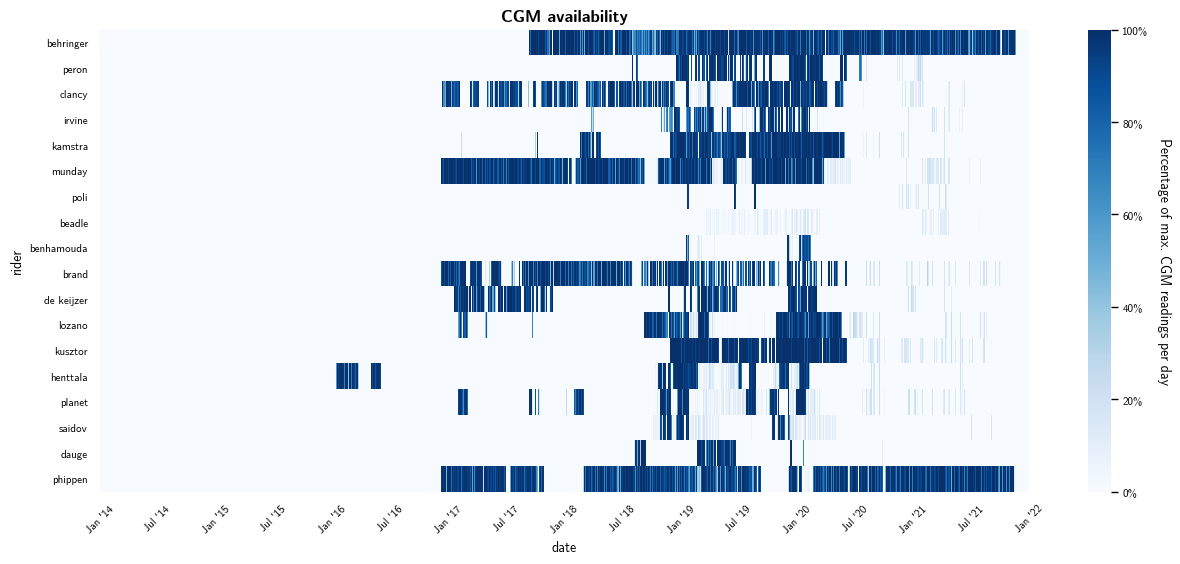

In [17]:
ax = plot_availability(dc_avail, rot_months=45, itv_months=6)
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', yticks=ax)

In [18]:
pro_list = pro.set_index('RIDER').stack().replace({'-':'np.nan'}).reset_index().rename(columns={'level_1':'year', 0:'pro'})
pro_list['year'] = pro_list['year'].astype(int)
pro_list.columns = pd.MultiIndex.from_product([pro_list.columns, ['']])
pro_list

RIDER  year     pro
                       
0       1  2014  np.nan
1       1  2015  np.nan
2       1  2016  np.nan
3       1  2017     DEV
4       1  2018     DEV
..    ...   ...     ...
139    18  2017     DEV
140    18  2018     DEV
141    18  2019     DEV
142    18  2020     DEV
143    18  2021     PRO

[144 rows x 3 columns]

In [19]:
# note that this is not an accurate list of pro's but is just used for demonstration
# (does not take into account start and end of the season)
tp_agg['year'] = tp_agg['date'].dt.year
tp_agg = pd.merge(tp_agg, pro_list, on=['RIDER', 'year'], how='left')
tp_agg = tp_agg.drop([('year')], axis=1)
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_max vertical_speed_sum   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_energy vertical_speed_peaks vertical_speed_rms   
0                       NaN                  NaN                NaN   
1                       NaN                  NaN                NaN   
2                       NaN                  NaN                NaN   
3                       NaN                  NaN                NaN   
4                       NaN                  NaN                NaN   
...                     ...                  ...                ...   
30207                   NaN                  NaN                NaN   
30208                   NaN                  NaN                NaN   
30209                   NaN                  NaN                NaN   
30210                   NaN                  NaN                NaN   
30211                   NaN                  NaN                NaN   

                                                                              \
      distance_up_iqr vertical_speed_iqr acceleration_iqr elevation_gain_iqr   
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              N

In [20]:
tp_avail = tp_agg.pivot(index='RIDER', columns='date', values='pro')
tp_avail = tp_avail.replace({'PRO':2, 'DEV':1, 'np.nan':np.nan})

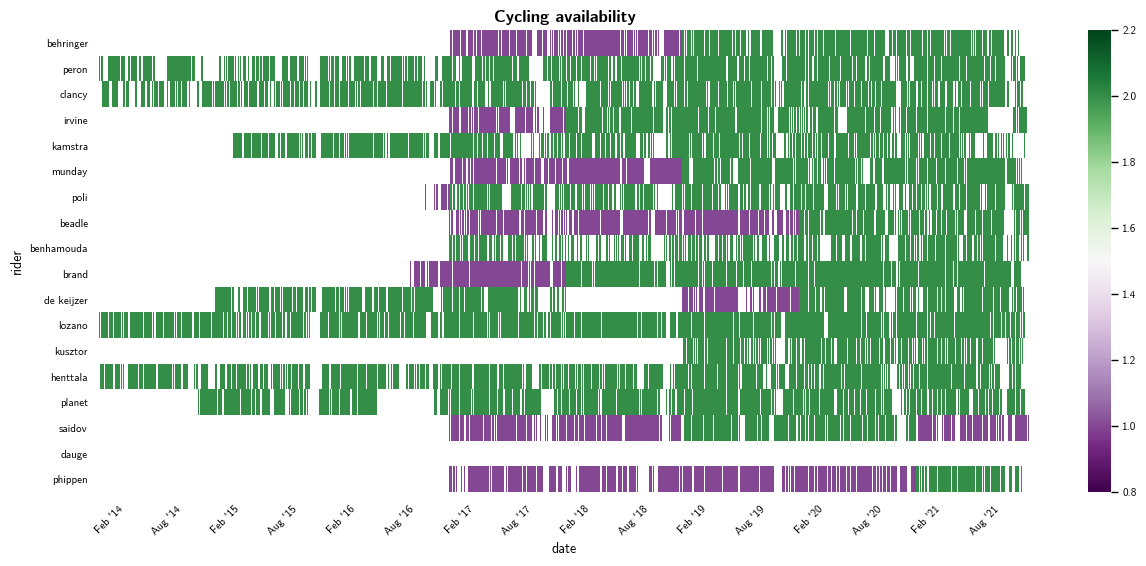

In [21]:
ax = plot_availability(tp_avail, cmap='PRGn', vmin=0.8, vmax=2.2, 
                       rot_months=45, itv_months=6, plot_colorbar=False)
plt.title('Cycling availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', dtype='TrainingPeaks', yticks=ax)

In [22]:
tp_agg = tp_agg.drop('pro', axis=1)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [23]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg.dropna(subset=['glucose_mean_day'])))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11785
Dexcom: N = 18 ; D = 11785


Identify exercise days

In [24]:
# identify exercise days
days_ex = dc.loc[dc['exercise'], ['RIDER', 'date']].drop_duplicates()
days_ex['exercise_day'] = True
days_ex = days_ex.set_index(['RIDER', 'date'])

dc = pd.merge(dc, days_ex, on=['RIDER', 'date'], how='left')
dc['exercise_day'] = dc['exercise_day'].fillna(False).astype(bool)

In [25]:
# rename columns so there is no confusion
dc = dc.rename(columns={'race':'race_day', 'travel':'travel_day'})

In [26]:
print("Race days: ", 
      len(dc.loc[dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Race days with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day'] & dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Training days: ", 
      len(dc.loc[dc['exercise_day'] & ~dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Exercise days: ", 
      len(dc.loc[dc['exercise_day'], ['RIDER', 'date']].drop_duplicates()))

Race days:  3710
Race days with CGM during exercise:  3202
Training days:  27042
Exercise days:  30244


Note: there are race days on which there is no CGM during exercise recorded!!! (Because exercise just tells us whether there is a part marked as exercise in the CGM data.)

Redefine day to be between 06am and 06am

In [27]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

cols_sleep = dc_agg.columns[dc_agg.columns.str.endswith('sleep')]
dc_agg[cols_sleep] = dc_agg.groupby('RIDER')[cols_sleep].apply(lambda x: x.shift(-1))

dc_agg = dc_agg.dropna(subset=['glucose_mean_'+i for i in ('exercise', 'recovery', 'sleep', 'wake')], how='all')
dc_agg = dc_agg.reset_index()

# note that everything ending with _day still has the old day definition in there 
# (so we should actually be dropping this as well)

In [28]:
dc['date_6h'] = pd.to_datetime((dc.local_timestamp - pd.to_timedelta('6h')).dt.date)

In [29]:
# align race and travel data with new dates
days = dc[['RIDER', 'date', 'race_day', 'travel_day', 'exercise_day']].drop_duplicates()
dc = pd.merge(dc, days, left_on=['RIDER', 'date_6h'], right_on=['RIDER', 'date'], how='left', suffixes=('', '_6h'))
dc = dc.loc[:,~dc.columns.duplicated()]
dc['race_day_6h'] = dc['race_day_6h'].astype(bool)
dc['travel_day_6h'] = dc['travel_day_6h'].astype(bool)
dc['exercise_day_6h'] = dc['exercise_day_6h'].astype(bool)

In [30]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  3727
Race days 6h with CGM during exercise:  3219
Training days 6h:  27042
Exercise days 6h:  30261


In [31]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11810
Dexcom: N = 18 ; D = 11808


Note: the difference between dc_agg and dc lies in the fact that there can be also glucose measurements in the sleep period that is now moved to the next day. (For instance, there is cgm data during a cycling session that took place between 5am and 6am.) For the dc data, now this cycling session is not accounted to this day but still to the previous day. For the dc_agg data, this is done correctly and it is taken into account for the next day. As we only use the dc data for calculating the statistics on a rider-level, we can just ignore the fact that this happens.

### Select data

Select riders that were pro in 2019

In [32]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [33]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')
hba1c = hba1c[hba1c.RIDER.isin(ATHLETES)].set_index('RIDER')

In [34]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom (agg): N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc[dc.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc[dc.RIDER.isin(ATHLETES)].dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 25116
Dexcom (agg): N = 14 ; D = 9248
Dexcom: N = 14 ; D = 9246


Select beginning and end of the training season in 2019

In [35]:
hba1c = hba1c['2019']
hba1c

RIDER
1     6.333333
2     6.533333
3     6.850000
4     8.000000
5     6.725000
6     6.550000
7     6.366667
9     7.025000
10    7.233333
12    5.950000
13    6.366667
14    6.925000
15    6.525000
16    6.825000
Name: 2019, dtype: float64

In [36]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

RIDER       date
0         1 2018-11-05
1         1 2018-11-06
2         1 2018-11-07
3         1 2018-11-08
4         1 2018-11-09
...     ...        ...
4642     16 2019-09-25
4643     16 2019-09-26
4644     16 2019-09-27
4645     16 2019-09-28
4646     16 2019-09-29

[4647 rows x 2 columns]

In [37]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


RIDER       date            TIME                       \
                      timestamp_count  local_timestamp_min   
0        1 2018-11-05          7767.0  2018-11-05 09:34:13   
1        1 2018-11-06          8065.0  2018-11-06 09:24:16   
2        1 2018-11-07         11349.0  2018-11-07 10:05:29   
3        1 2018-11-08          7649.0  2018-11-08 09:52:38   
4        1 2018-11-09         11297.0  2018-11-09 11:14:27   
...    ...        ...             ...                  ...   
3823    16 2019-09-22          7113.0  2019-09-22 10:00:18   
3824    16 2019-09-24          6530.0  2019-09-24 15:39:16   
3825    16 2019-09-27          7462.0  2019-09-27 14:50:03   
3826    16 2019-09-28          3157.0  2019-09-28 07:48:34   
3827    16 2019-09-29          3188.0  2019-09-29 08:00:16   

                                               CALENDAR                      \
      local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0     2018-11-05 11:44:12                  1.0    False  False          0.0   
1     2018-11-06 11:51:24                  1.0    False  False          0.0   
2     2018-11-07 14:45:37                  2.0    False  False          0.0   
3     2018-11-08 12:00:51                  1.0    False  False          0.0   
4     2018-11-09 14:30:32                  1.0    False  False          0.0   
...                   ...                  ...      ...    ...          ...   
3823  2019-09-22 11:58:50                  1.0     True  False          1.0   
3824  2019-09-24 17:33:43                  1.0    False   True          0.5   
3825  2019-09-27 16:56:26                  1.0    False  False          0.0   
3826  2019-09-28 11:16:50                  3.0    False  False          0.0   
3827  2019-09-29 10:33:36                  2.0    False  False          0.0   

                   ...                LOC                     \
     race_7d_mean  ... vertical_speed_min vertical_speed_max   
0            0.00  ...                NaN                NaN   
1            0.00  ...                NaN                NaN   
2            0.00  ...                NaN                NaN   
3            0.00  ...                NaN                NaN   
4            0.00  ...                NaN                NaN   
...           ...  ...                ...                ...   
3823         1.00  ...                NaN                NaN   
3824         0.75  ...                NaN                NaN   
3825         0.50  ...                NaN                NaN   
3826         0.25  ...                NaN                NaN   
3827         0.00  ...                NaN                NaN   

                                                                    \
     vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   
...                 ...                   ...                  ...   
3823                NaN                   NaN                  NaN   
3824                NaN                   NaN                  NaN   
3825                NaN                   NaN                  NaN   
3826                NaN                   NaN                  NaN   
3827                NaN                   NaN                  NaN   

                                                                             \
     vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                   NaN             NaN                NaN              NaN   
1                   NaN             NaN                NaN              NaN   
2                   NaN             NaN                NaN              NaN   
3                   NaN        

In [38]:
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg

RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0         1 2018-11-05                   10.0                      4.0   
1         1 2018-11-06                    1.0                      0.0   
2         1 2018-11-07                   27.0                     10.0   
3         1 2018-11-08                   10.0                      1.0   
4         1 2018-11-09                    3.0                      0.0   
...     ...        ...                    ...                      ...   
3066     16 2019-04-25                    2.0                      0.0   
3067     16 2019-04-26                    0.0                      0.0   
3068     16 2019-04-27                    0.0                      0.0   
3069     16 2019-04-30                    0.0                      0.0   
3070     16 2019-08-12                    0.0                      0.0   

      time_in_hypoL1_exercise  time_in_target_exercise  \
0                         6.0                      2.0   
1                         1.0                     19.0   
2                        17.0                     25.0   
3                         9.0                     16.0   
4                         3.0                     32.0   
...                       ...                      ...   
3066                      2.0                     42.0   
3067                      0.0                     22.0   
3068                      0.0                     11.0   
3069                      0.0                      0.0   
3070                      0.0                     24.0   

      time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        5.0                       5.0   
3                        0.0                       0.0   
4                        5.0                       5.0   
...                      ...                       ...   
3066                     1.0                       1.0   
3067                     0.0                       0.0   
3068                     9.0                       9.0   
3069                    25.0                      23.0   
3070                     0.0                       0.0   

      time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_day  \
0                          0.0              59.500000  ...        56.705728   
1                          0.0             128.550000  ...        35.423009   
2                          0.0              85.333333  ...        50.113354   
3                          0.0              73.115385  ...        43.911998   
4                          0.0             110.375000  ...        51.618469   
...                        ...                    ...  ...              ...   
3066                       0.0             110.266667  ...        29.171995   
3067                       0.0             129.545455  ...        19.308837   
3068                       0.0             169.050000  ...        38.900667   
3069                       2.0             239.480000  ...         8.651901   
3070                       0.0             115.166667  ...        17.464664   

      glucose_cv_day  glucose_rate_day  completeness_day  count_day  LBGI_day  \
0           0.441880        128.328302          0.920139        265  2.419600   
1           0.334281        105.967626          0.965278        278  2.871435   
2           0.498897        100.448276          0.906250        261  7.604452   
3           0.378438        116.034722          1.000000        288  2.116019   
4           0.492795        104.746377          0.958333        276  5.616227   
...              ...               ...               ...        ...       ...   
3066        0.264729        110.195652          0.159722         46  0.266075   
3067        0.149051        129.545455          0.076389         22  0.002101   
3068        0.233604        166.523810       

In [39]:
dc = pd.merge(dc, season_list, how='inner', left_on=['RIDER', 'date_6h'], right_on=['RIDER', 'date'])
dc = dc.drop('date_y', axis=1)
dc = dc.rename(columns={'date_x':'date'})
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            1 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            1 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            1 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            1 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            1 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1338067     16 2019-09-30 09:35:00                    NaN 2019-09-30 05:35:00   
1338068     16 2019-09-30 09:40:00                    NaN 2019-09-30 05:40:00   
1338069     16 2019-09-30 09:45:00                    NaN 2019-09-30 05:45:00   
1338070     16 2019-09-30 09:50:00                    NaN 2019-09-30 05:50:00   
1338071     16 2019-09-30 09:55:00                    NaN 2019-09-30 05:55:00   

         exercise  recovery   wake  sleep  race_day  travel_day       date  \
0           False     False   True  False     False       False 2018-11-05   
1           False     False   True  False     False       False 2018-11-05   
2           False     False   True  False     False       False 2018-11-05   
3           False     False   True  False     False       False 2018-11-05   
4           False     False   True  False     False       False 2018-11-05   
...           ...       ...    ...    ...       ...         ...        ...   
1338067     False     False  False   True     False       False 2019-09-30   
1338068     False     False  False   True     False       False 2019-09-30   
1338069     False     False  False   True     False       False 2019-09-30   
1338070     False     False  False   True     False       False 2019-09-30   
1338071     False     False  False   True     False       False 2019-09-30   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  
0                True 2018-11-05        False          False             True  
1                True 2018-11-05        False          False             True  
2                True 2018-11-05        False          False             True  
3                True 2018-11-05        False          False             True  
4                True 2018-11-05        False          False             True  
...               ...        ...          ...            ...              ...  
1338067         False 2019-09-29        False          False             True  
1338068         False 2019-09-29        False          False             True  
1338069         False 2019-09-29        False          False             True  
1338070         False 2019-09-29        False          False             True  
1338071         False 2019-09-29        False          False             True  

[1338072 rows x 16 columns]

In [40]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 3071
Dexcom: N = 14 ; D = 3071


In [41]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  479
Race days 6h with CGM during exercise:  466
Training days 6h:  3362
Exercise days 6h:  3828


#### Glucose completeness

In [42]:
completeness = pd.read_csv(DATA_PATH+'agg/dexcom_completeness_6h.csv', index_col=0)
completeness = completeness.rename(columns={'0':'completeness'})
completeness['date_6h'] = pd.to_datetime(completeness['date_6h'])
completeness

RIDER    date_6h  completeness
0          1 2013-12-31           0.0
1          1 2014-01-01           0.0
2          1 2014-01-02           0.0
3          1 2014-01-03           0.0
4          1 2014-01-04           0.0
...      ...        ...           ...
52609     18 2021-12-27           0.0
52610     18 2021-12-28           0.0
52611     18 2021-12-29           0.0
52612     18 2021-12-30           0.0
52613     18 2021-12-31           0.0

[52614 rows x 3 columns]

In [43]:
dc_agg = pd.merge(dc_agg, completeness, left_on=['RIDER', 'date'], right_on=['RIDER', 'date_6h'], how='left')
dc_agg = dc_agg.drop('date_6h', axis=1)

In [44]:
dc = pd.merge(dc, completeness, on=['RIDER', 'date_6h'], how='left')

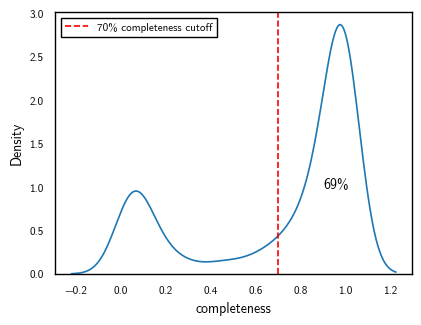

In [46]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness')
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,1, '{:.0f}%'.format((dc_agg['completeness'] >= 0.7).sum()/dc_agg['completeness'].count()*100))
plt.legend()
plt.show()

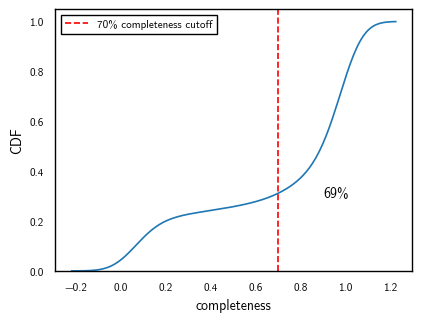

In [48]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness', cumulative=True)
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,0.3, '{:.0f}%'.format((dc_agg['completeness'] >= 0.7).sum()/dc_agg['completeness'].count()*100))
plt.legend()
plt.ylabel('CDF')
plt.savefig(SAVE_PATH+'completeness_cutoff_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

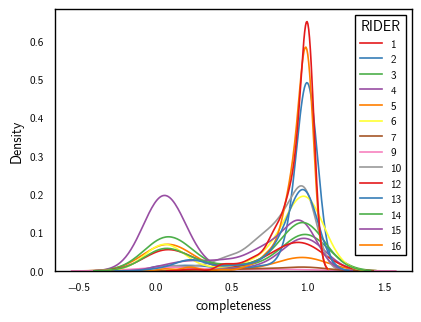

In [49]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness', hue='RIDER', palette='Set1')
plt.show()

Calendar with glucose availability

In [50]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness')

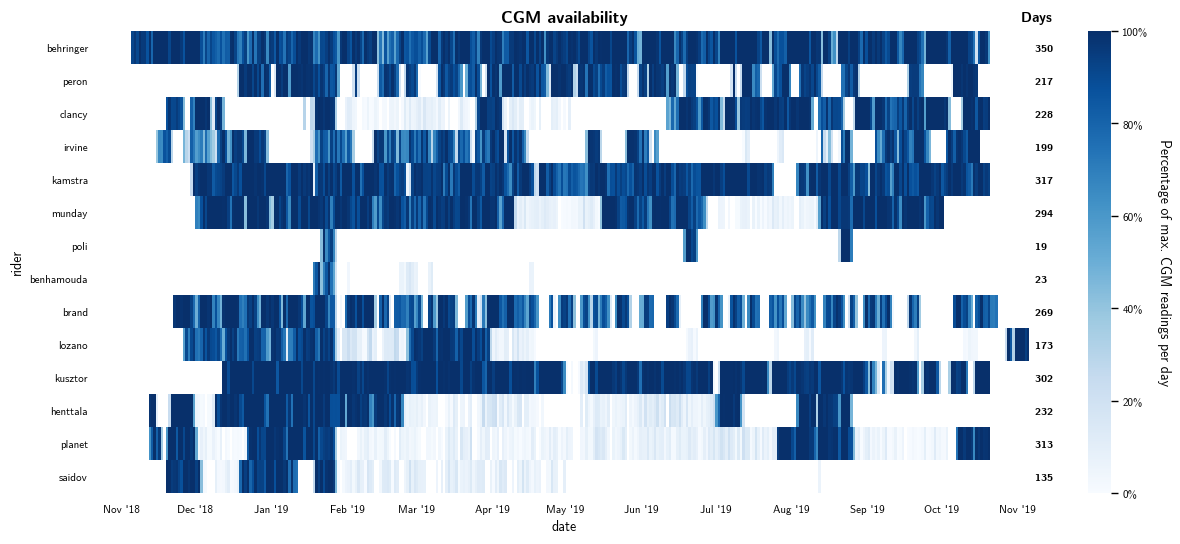

In [51]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability', yticks=ax)

Select data with glucose completeness >= 70% (on a day from 6am to 6am) and remove nans from dexcom data

In [52]:
dc.loc[dc['completeness'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [53]:
dc_agg = dc_agg[dc_agg['completeness'] >= 0.7]

In [54]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 2133
Dexcom: N = 14 ; D = 2133


In [55]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  270
Race days 6h with CGM during exercise:  265
Training days 6h:  1543
Exercise days 6h:  1808


Select participants with 14 or more days of data

In [56]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index

info = info.loc[ATHLETES]
season_list = season_list[season_list.RIDER.isin(ATHLETES)]
hba1c = hba1c.loc[ATHLETES]

tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]
dc = dc[dc.RIDER.isin(ATHLETES)]

In [57]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 12 ; D = 3370
Dexcom (agg): N = 12 ; D = 2115
Dexcom: N = 12 ; D = 2115


In [58]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  261
Race days 6h with CGM during exercise:  256
Training days 6h:  1534
Exercise days 6h:  1790


Incorporate HbA1c in info

In [59]:
info = info.drop('HbA1c', axis=1)
hba1c.name = 'HbA1c'
info = pd.merge(info, hba1c, left_index=True, right_index=True, how='left')
info

gender  nationality  age  diabetes_duration     weight     bf(%)  \
RIDER                                                                    
1          M  Switzerland   22                 11  60.500000  9.066667   
2          M        Italy   30                 14  71.633333  8.833333   
3          M      Ireland   26                  7  66.733333  6.566667   
4          M    Australia   19                  7  78.666667  9.433333   
5          M  Netherlands   25                  6  69.633333  7.700000   
6          M    Australia   20                  9  56.700000  4.950000   
10         M           UK   27                 17  75.466667  7.700000   
12         M        Spain   30                  8  64.000000  5.600000   
13         M      Hungary   34                  1  60.333333  4.866667   
14         M      Finland   27                 17  75.166667  9.333333   
15         M       France   25                 15  73.766667  7.200000   
16         M   Uzbekistan   22                 13  56.666667  9.466667   

              FTP        LTHR       HRmax     VO2max  height     HbA1c  
RIDER                                                                   
1      307.000000  176.333333  192.333333  68.888889   174.0  6.333333  
2      326.000000  168.666667  181.666667  66.915285   178.0  6.533333  
3      298.000000  171.000000  180.000000  66.666164   171.0  6.850000  
4      356.000000  170.333333  187.333333  67.333333   178.0  8.000000  
5      341.000000  179.666667  192.666667  72.857143   183.0  6.725000  
6      298.500000  173.000000  184.500000  70.781588   169.0  6.550000  
10     377.333333  177.000000  194.333333  73.982571   185.0  7.233333  
12     347.000000  158.333333  178.666667  75.937500   178.0  5.950000  
13     345.666667  173.000000  182.333333  76.666667   179.0  6.366667  
14     348.000000  169.000000  189.500000  66.500000   187.0  6.925000  
15     389.000000  185.000000  198.000000  66.000000   179.0  6.525000  
16     283.333333  125.610000  200.333333  74.678571   170.0  6.825000

**Give participants a new ID (so that it is not confusing for the paper)**

In [60]:
def get_percinlevel(dc, col='Glucose Value (mg/dL)'):
	return {level: ((dc[col] >= lmin) & (dc[col] <= lmax)).sum() / len(dc)*100 for level, (lmin, lmax) in glucose_levels.items()}

In [61]:
tir = pd.Series({i: get_percinlevel(dc[dc.RIDER == i])['target'] for i in ATHLETES}).sort_values(ascending=False)

In [62]:
new_mapping = {i: n+1 for n, (i, _) in enumerate(tir.iteritems())}
new_mapping

{13: 1,
 6: 2,
 5: 3,
 12: 4,
 15: 5,
 3: 6,
 2: 7,
 1: 8,
 16: 9,
 14: 10,
 4: 11,
 10: 12}

In [63]:
ATHLETES = sorted([*map(new_mapping.get, ATHLETES)])

info.index = info.index.map(new_mapping)
info = info.sort_index()

season.index = season.index.map(new_mapping)
season = season.sort_index()

season_list.RIDER = season_list.RIDER.map(new_mapping)

tp_agg.RIDER = tp_agg.RIDER.map(new_mapping)
dc_agg.RIDER = dc_agg.RIDER.map(new_mapping)
dc.RIDER = dc.RIDER.map(new_mapping)

rider_mapping_inv = {new_mapping[k]:v for k,v in rider_mapping_inv.items() if k in new_mapping.keys()}

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [64]:
def savefig(path, i='', dtype='Dexcom', legend=None, title=None, xticks=None, yticks=None, **titlekwargs):
    if title is not None:
        plt.title(r'$\bf{Cyclist}$ '+r'$\bf{:d}$ - '.format(i)+title, **titlekwargs)
    if legend is not None:
        for text in legend:
            text.set_fontsize(6)
    
    plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf', bbox_inches='tight')
    plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=300, bbox_inches='tight')
    
    if title is not None:
        plt.title(r'$\bf{:s}$ '.format(rider_mapping_inv[i])+title, **titlekwargs)
    if legend is not None:
        for leg in legend:
            text = leg.get_text().split()
            leg.set_text(rider_mapping_inv[int(text[0])]+' '+' '.join(text[1:]))
    if xticks is not None:
        xticks.set_xticklabels([rider_mapping_inv[int(j.get_text())] for j in xticks.get_xticklabels()], rotation=90)
    if yticks is not None:
        yticks.set_yticklabels([rider_mapping_inv[int(j.get_text())] for j in yticks.get_yticklabels()], rotation=0)
    
    if title is not None or legend is not None or xticks is not None or yticks is not None:
        plt.savefig(f'{SAVE_PATH}{dtype}/{path}_NAME_{i}.pdf', bbox_inches='tight')
        plt.savefig(f'{SAVE_PATH}{dtype}/{path}_NAME_{i}.png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

In [65]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness')

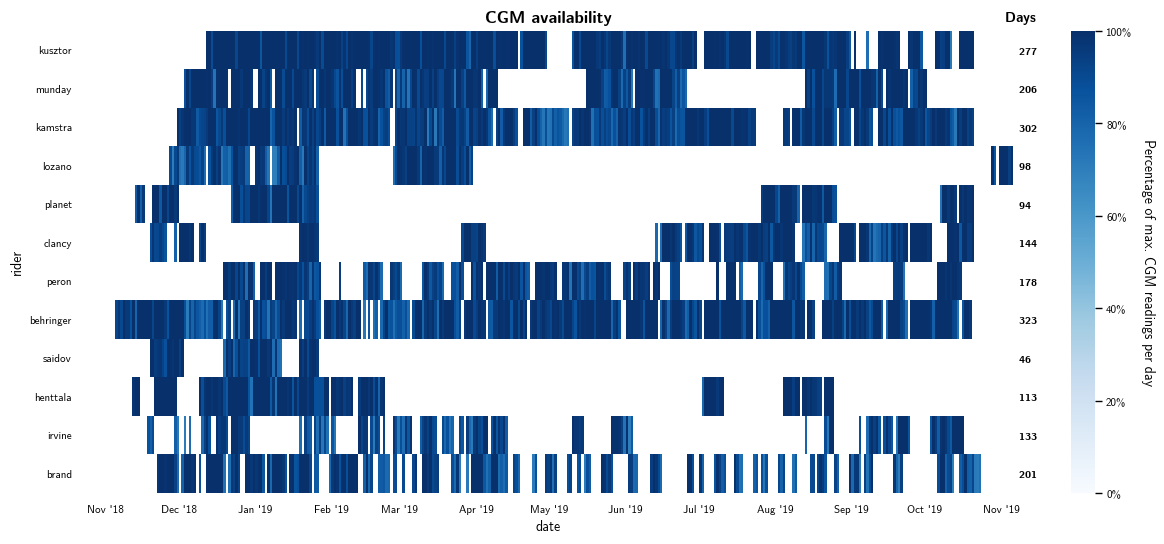

In [66]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_selectcomp', yticks=ax)

## Descriptives Dexcom

### Glucose distribution (histograms)

All data

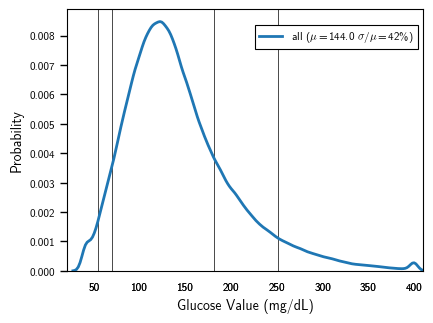

In [72]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='hist/hist_glucose')

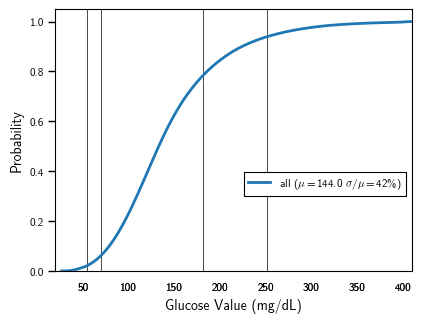

In [78]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, cumulative=True, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
ax.set_xlabel(COL)
savefig(path='cdf/cdf_glucose')

All, hue: sections

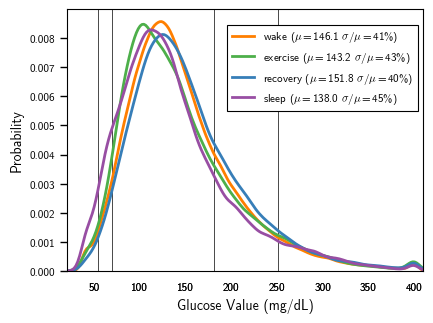

In [74]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_sec')

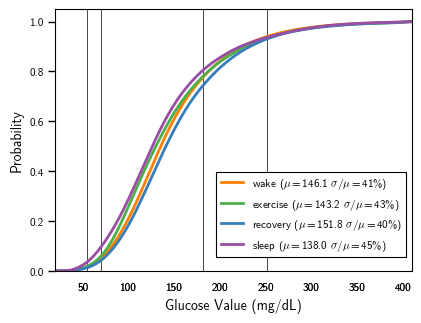

In [79]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, cumulative=True, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
savefig(path='cdf/cdf_glucose_sec')

Individual athletes, hue: sections

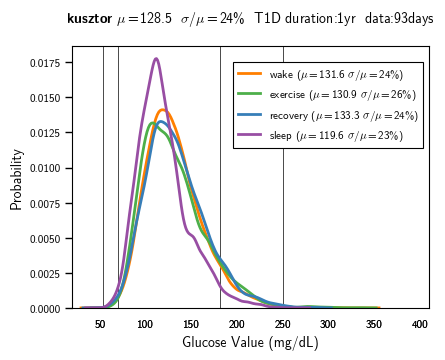

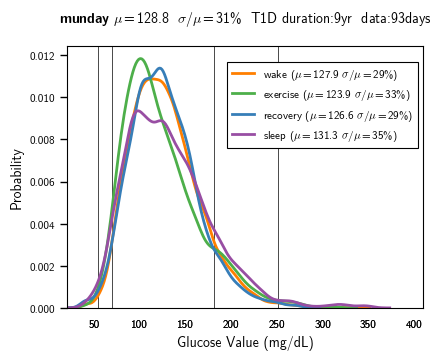

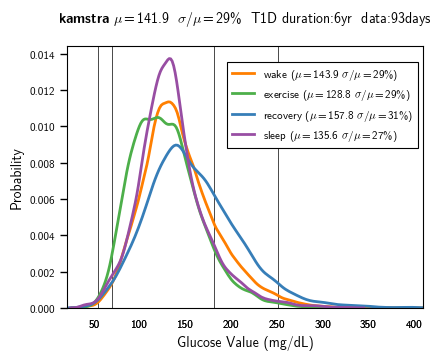

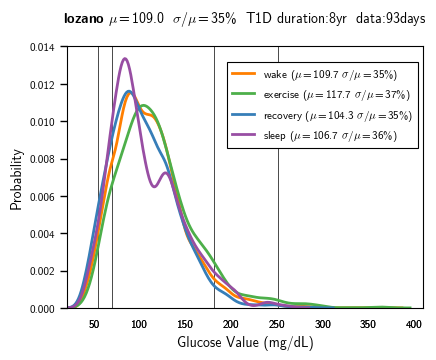

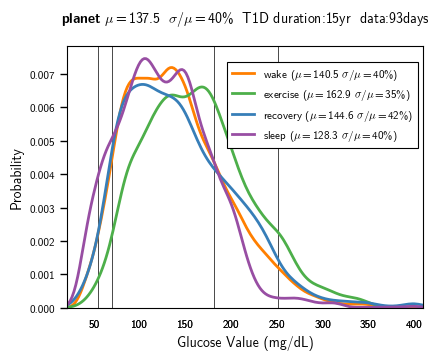

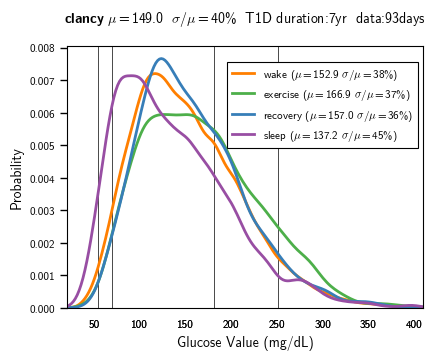

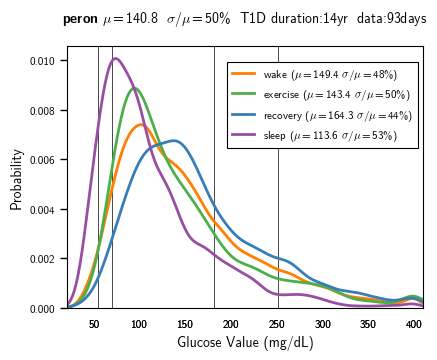

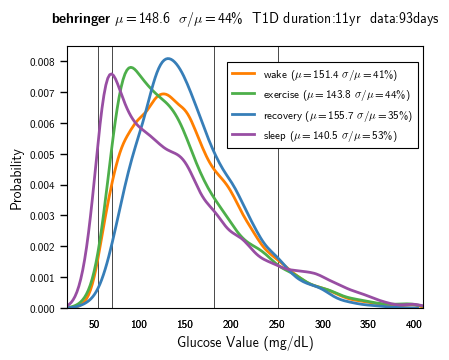

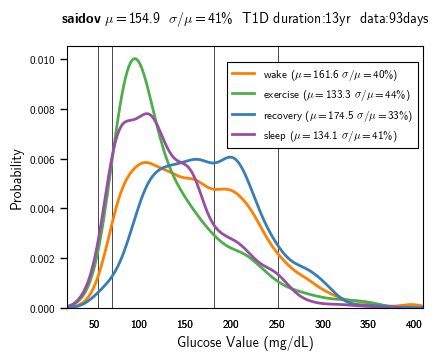

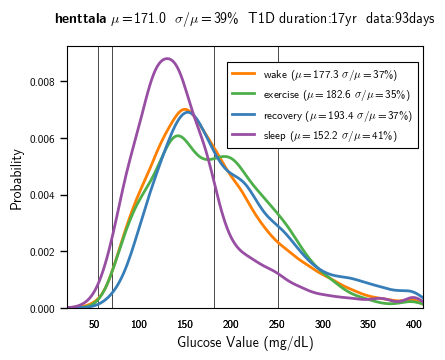

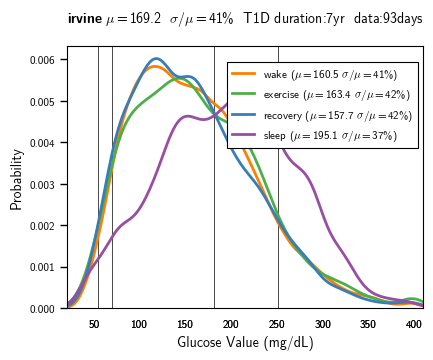

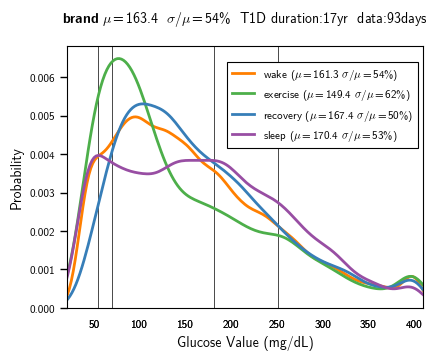

In [76]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='hist/hist_glucose_rider', i=i, title=title, y=1.06)

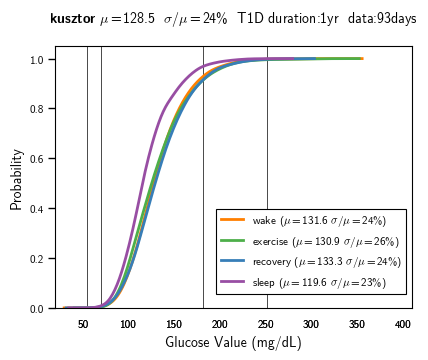

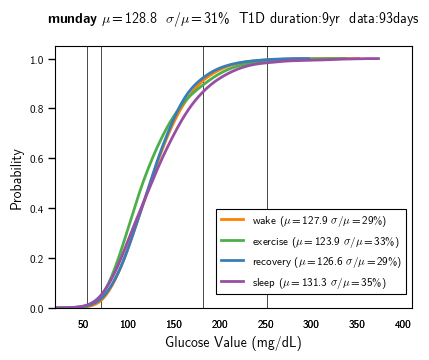

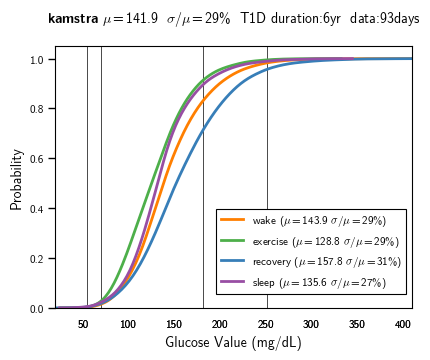

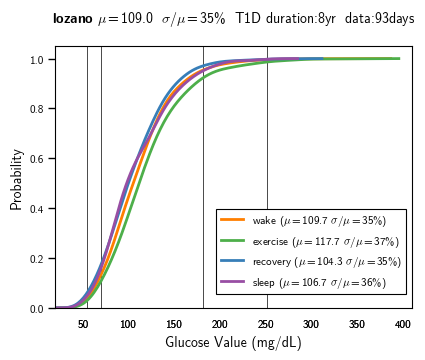

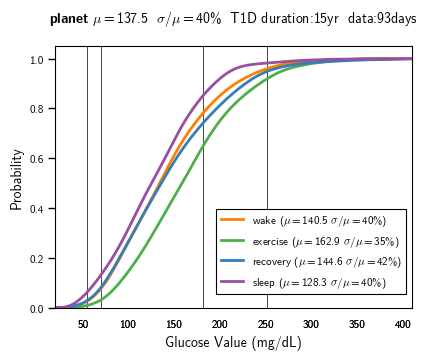

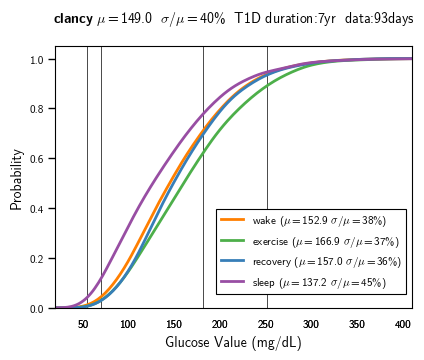

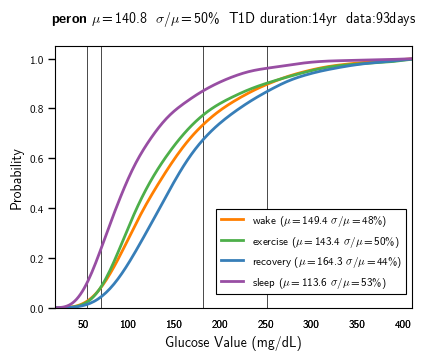

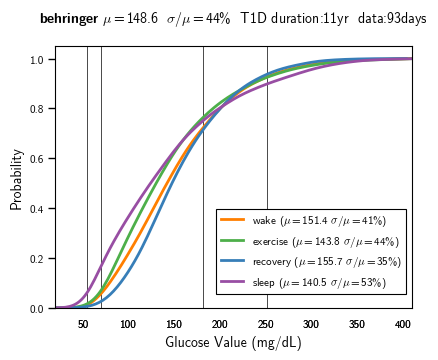

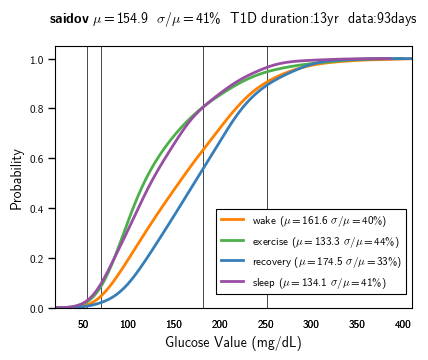

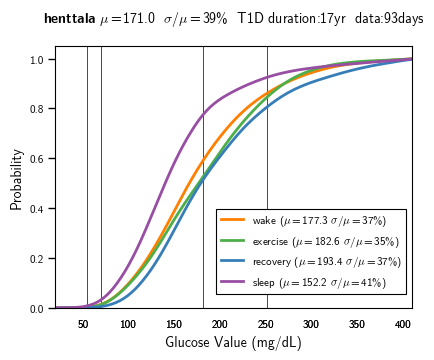

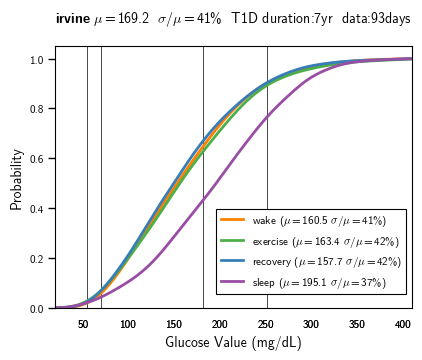

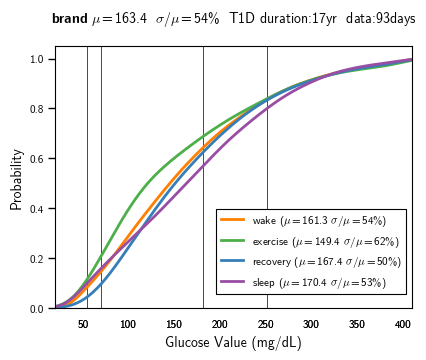

In [80]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, cumulative=True, 
			linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='cdf/cdf_glucose_rider', i=i, title=title, y=1.06)

All, hue: athletes

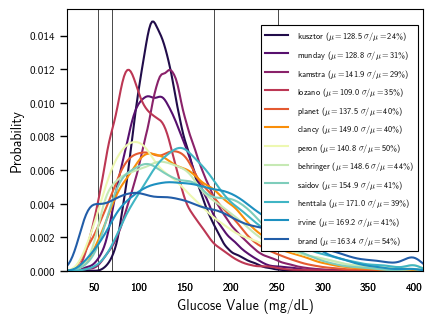

In [83]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_riders', legend=ax.get_legend().get_texts())

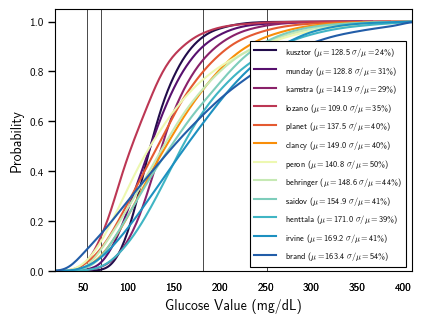

In [85]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, cumulative=True,
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
savefig(path='cdf/cdf_glucose_riders', legend=ax.get_legend().get_texts())

Sections individually, hue: athletes

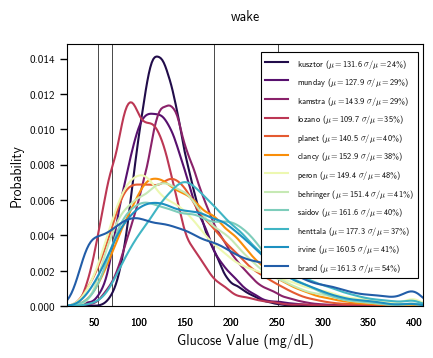

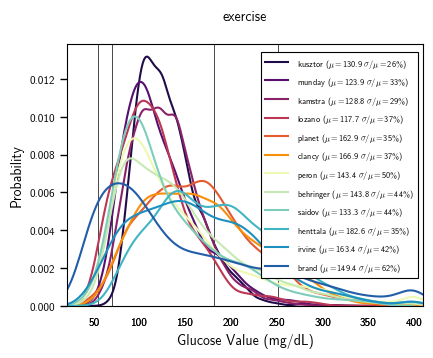

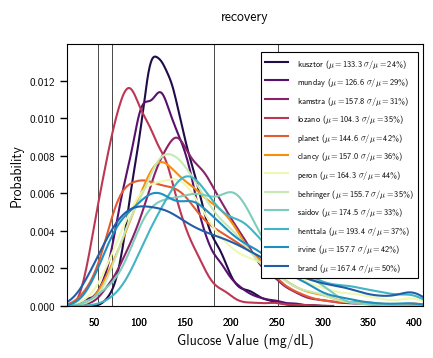

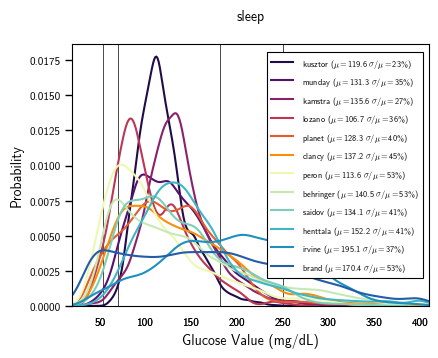

In [88]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.99))
	plt.title(sec, y=1.06)
	savefig(path='hist/hist_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

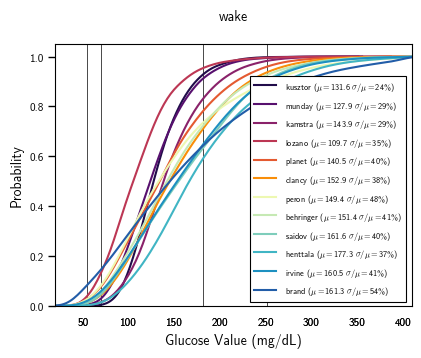

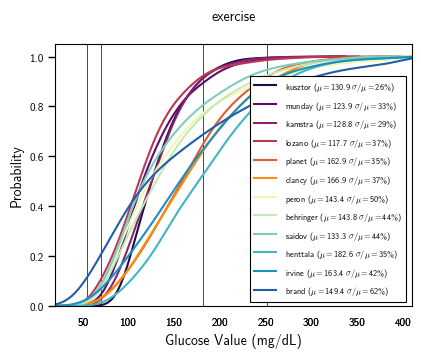

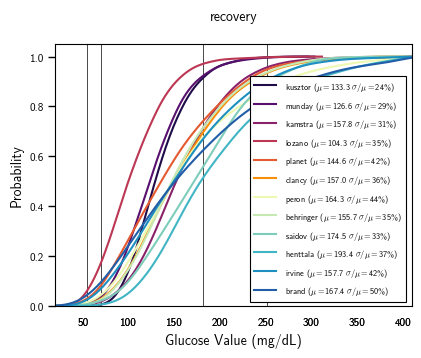

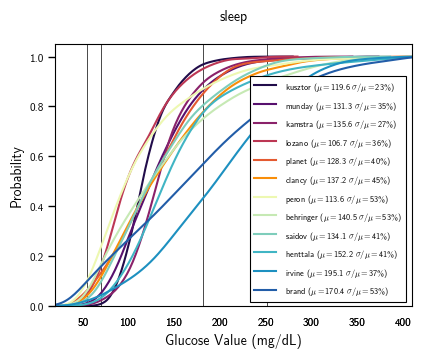

In [89]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			cumulative=True, linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
	plt.title(sec, y=1.06)
	savefig(path='cdf/cdf_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

**CONCLUSION** : Large differences among athletes

### Glucose time in level (barcharts)

Sort athletes by diabetes duration

In [97]:
"""
tir = pd.Series({i: get_percinlevel(dc[dc.RIDER == i])['target'] for i in ATHLETES})

#idx_sort = info['diabetes_duration'].argsort()
idx_sort = tir.argsort()[::-1]

ATHLETES = np.array(ATHLETES)[idx_sort]
info = info.iloc[idx_sort]
"""

In [187]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
    for c, l, h in zip([(0, 0, 0), (.5, .5, .5), (.9, .9, .9), (.5, .5, .5), (0, 0, 0)],#sns.diverging_palette(10, 10, s=0, n=5), 
                       ['>250 mg/dL', '>180-250 mg/dL', '70-180 mg/dL', '<70-54 mg/dL', '<54 mg/dL'], 
                       ('//', '//', None, '\\\\', '\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

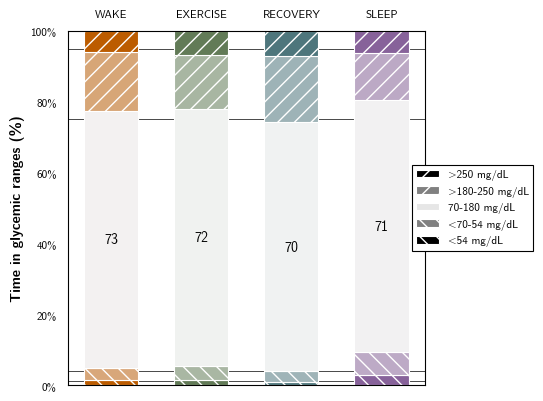

In [188]:
# TODO: now it is dominated by athletes that have the most data, 
# we should calculate it for riders individually and then average
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec]])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel')

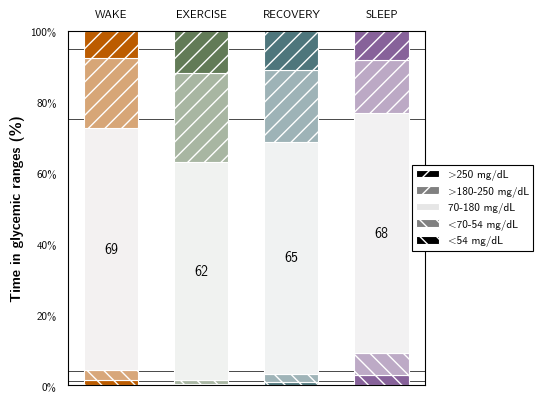

In [189]:
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & dc['race_day'] & dc['exercise_day']])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel_competition')

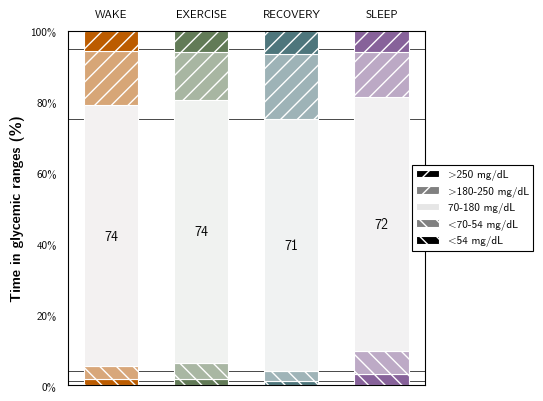

In [190]:
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & ~dc['race_day'] & dc['exercise_day']])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel_training')

Individual athletes, hue: stages

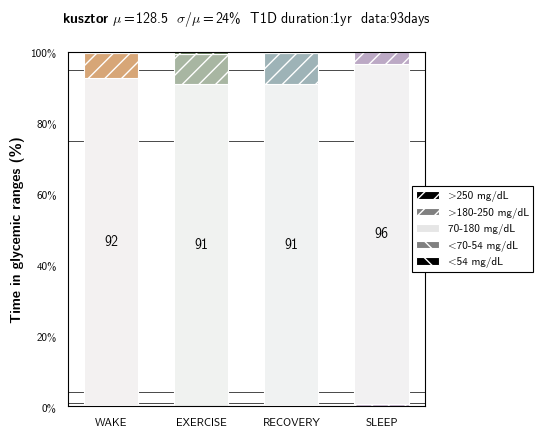

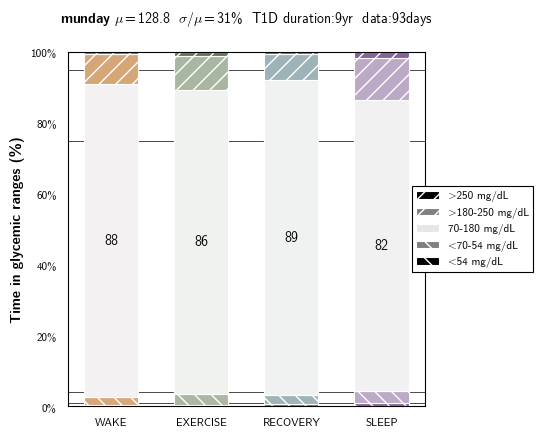

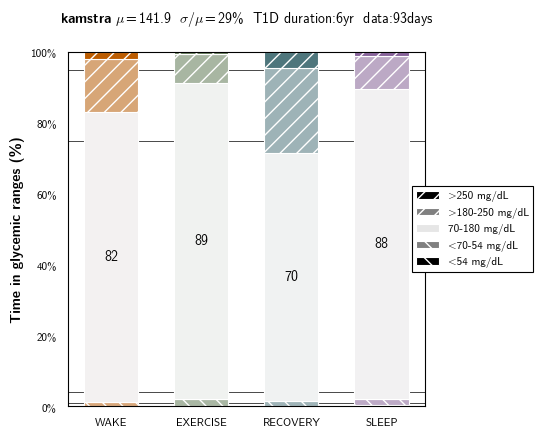

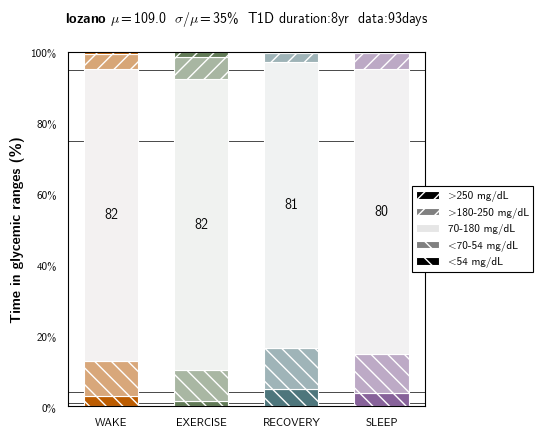

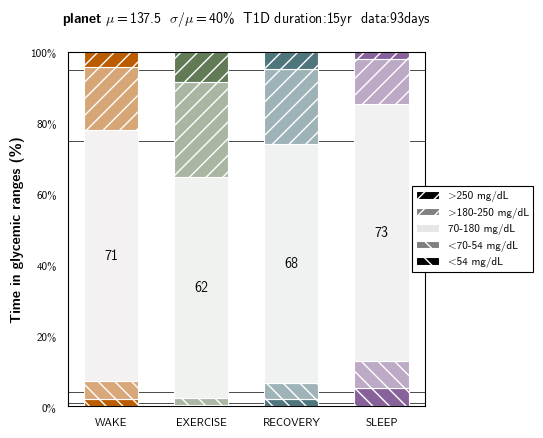

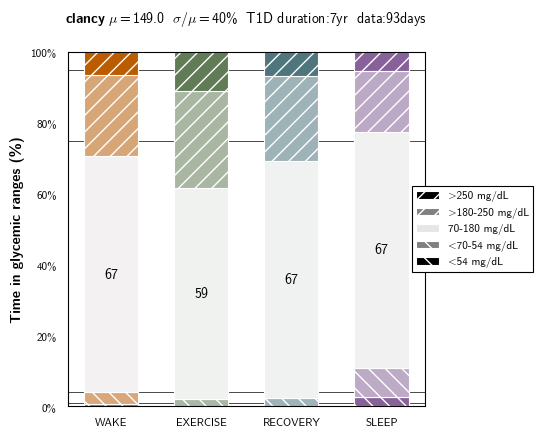

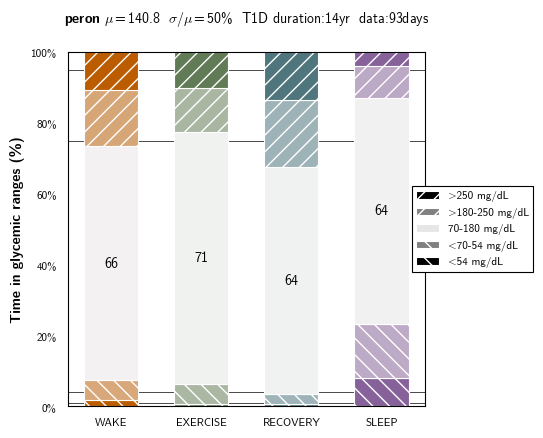

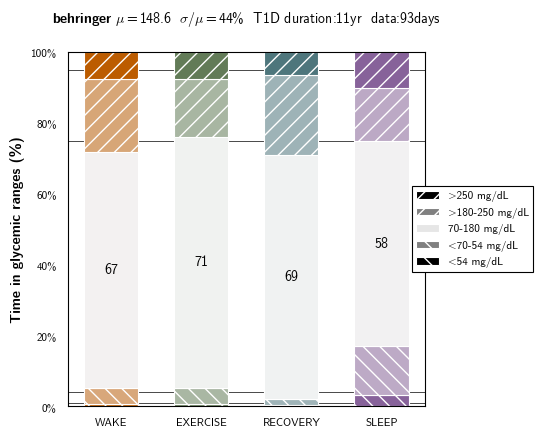

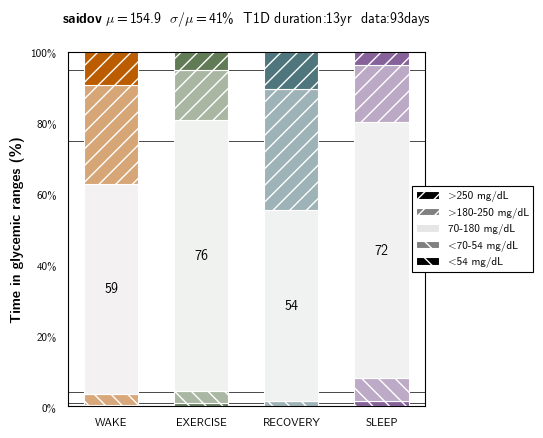

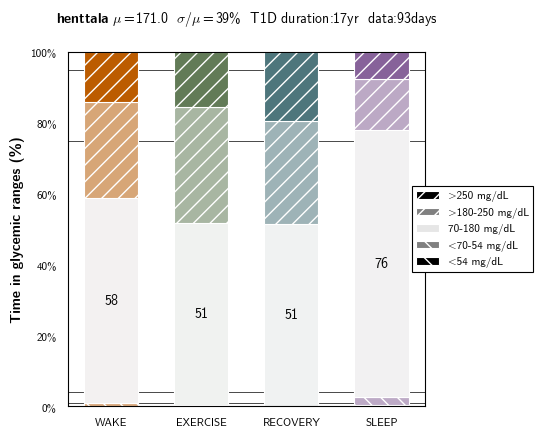

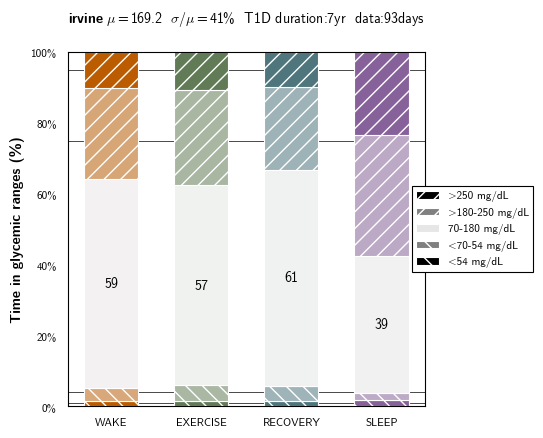

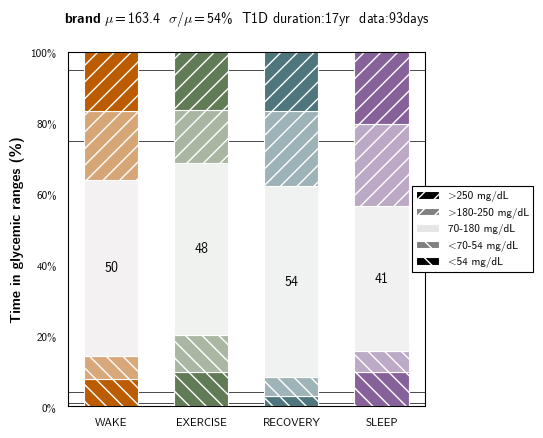

In [191]:
# TODO: check if calculation of perc_in_level is now correct!! (irvine looks weird!)
for i in ATHLETES:
    fig, ax = plt.subplots(figsize=(4.6, 4.6))

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i)])
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half')

    plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
    plt.ylim((0,100))
    plt.ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.set_xticklabels([sec.upper() for sec in SECTIONS])

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
    sns.despine(ax=ax, bottom=False, right=False, top=False)
    ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg.loc[i]))
    savefig(path='time_in_zone/time_in_glucoselevel', i=i, title=title, y=1.06)

All, hue: athletes

In [315]:
colorful=False

In [337]:
if colorful:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in palette_ath]]
    kws = dict(ref_color = dict(h_neg=10, h_pos=10, s=0, l=50),
               ref_color_rgb = 'black',
               dur_color = 'black',
               dur_cmap = 'Greys')
else:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in len(palette_ath)*[(0, 0, 0)]]]
    kws = dict(ref_color = dict(h_pos=360, h_neg=360, l=50, s=80),
               ref_color_rgb = sns.diverging_palette(h_pos=360, h_neg=360, l=50, s=80, n=5)[0],
               dur_color = sns.diverging_palette(h_pos=67, h_neg=67, l=50, s=80, n=5)[0],
               dur_cmap = sns.light_palette((67/360, 50/360, 80/100), input='hls', as_cmap=True))

In [338]:
def plot_bar_reference(ax, n, colors=dict(h_neg=10, h_pos=10, s=0, l=50), text=True):
    ax.plot((n+1-0.2, n+1-0.2), (0, 110), color='black', clip_on=False)
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             x=n+1.5, width=.7, plot_numbers='full', ax=ax, labelsize=8, colors=colors)
    ax.annotate('3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    ax.annotate('1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    if text:
        ax.text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=sns.diverging_palette(**colors, n=5)[0])

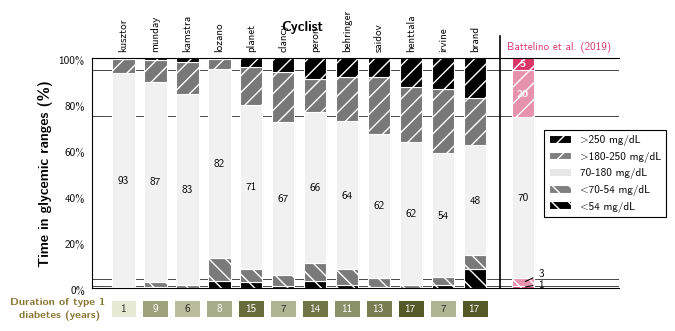

In [339]:
fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,3.4), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

# plot bars
for n, i in enumerate(ATHLETES):
    pil = get_percinlevel(dc[dc.RIDER == i])
    plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
             ax=ax, plot_numbers='half', labelsize=8)

# plot reference
plot_bar_reference(ax, n, colors=kws['ref_color'])
    
# ticks and axes
ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
ax.set_xlim((-1, 15.5))
ax.set_ylim((0,100))
ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
ax.set_xlabel('Cyclist', weight='bold')
ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

if colorful:
    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=ax, bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
ax0.set_xlim((-0.5, 16))
ax0.set_xlabel(None)
ax0.text(-1.5, 0.3, 'Duration of type 1 ', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
ax0.text(-1.5, 0.9, 'diabetes (years)', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders', xticks=ax)

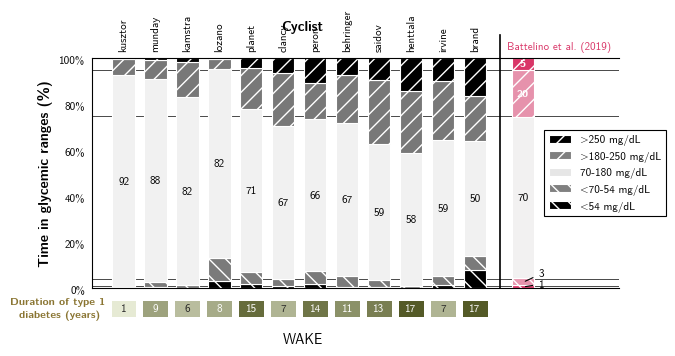

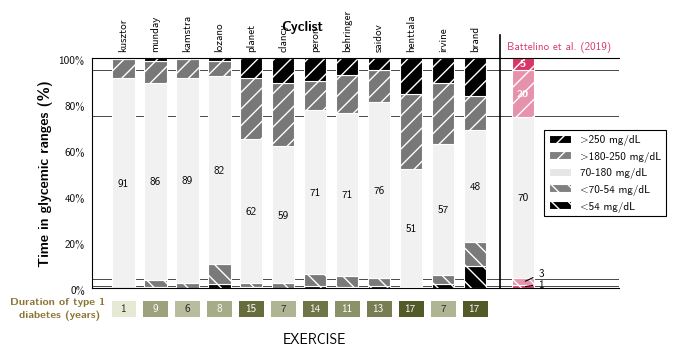

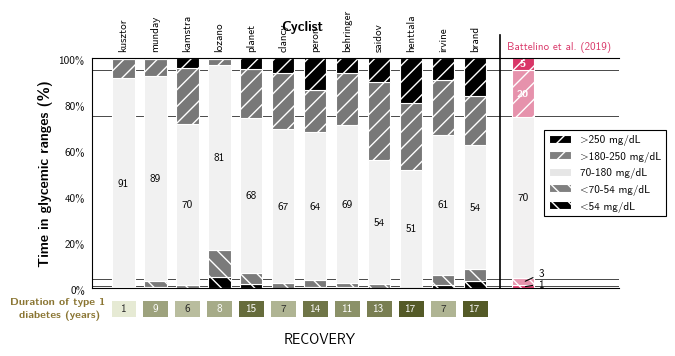

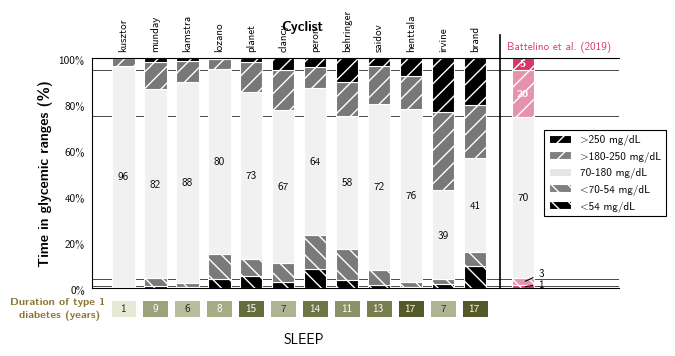

In [340]:
for sec in SECTIONS:
    fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,3.4), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
                 ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'])
    
    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
    ax.set_xlabel('Cyclist', weight='bold')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_label_coords(0.4, 1.12)
    ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
    sns.despine(ax=ax, bottom=False, right=True, top=False)

    # diabetes duration on bottom
    sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
                annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
    ax0.set_xlim((-0.5, 16))
    ax0.set_xlabel(None)
    ax0.text(-1.5, 0.3, 'Duration of type 1 ', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
    ax0.text(-1.5, 0.9, 'diabetes (years)', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

    ax0.text(n/2, 2, sec.upper())
    
    savefig('time_in_zone/time_in_glucoselevel_riders_%s'%sec, xticks=ax)

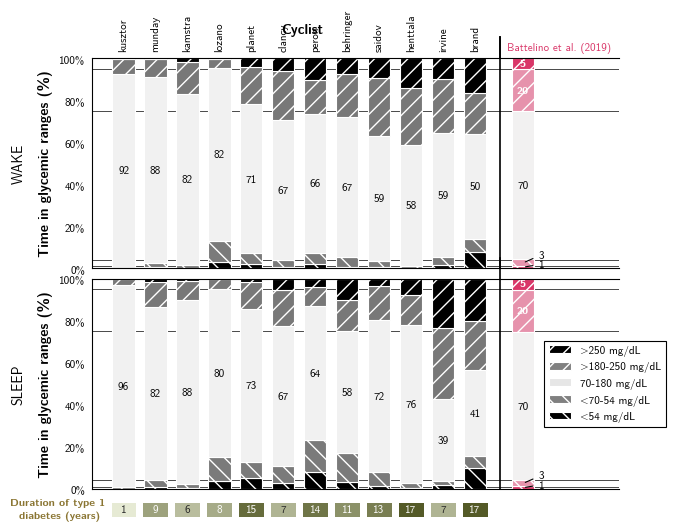

In [341]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('wake', 'sleep')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Cyclist', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.5, 0.3, 'Duration of type 1 ', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.5, 0.9, 'diabetes (years)', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_daynight', xticks=axs[0])

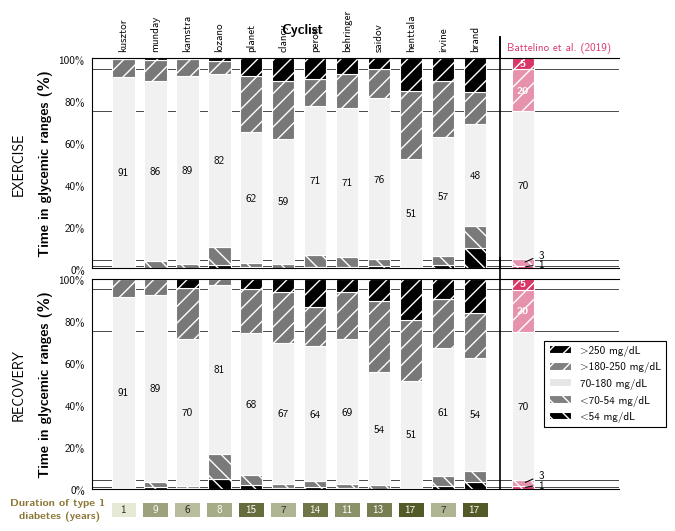

In [342]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('exercise', 'recovery')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Cyclist', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.5, 0.3, 'Duration of type 1 ', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.5, 0.9, 'diabetes (years)', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_exerciserecovery', xticks=axs[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


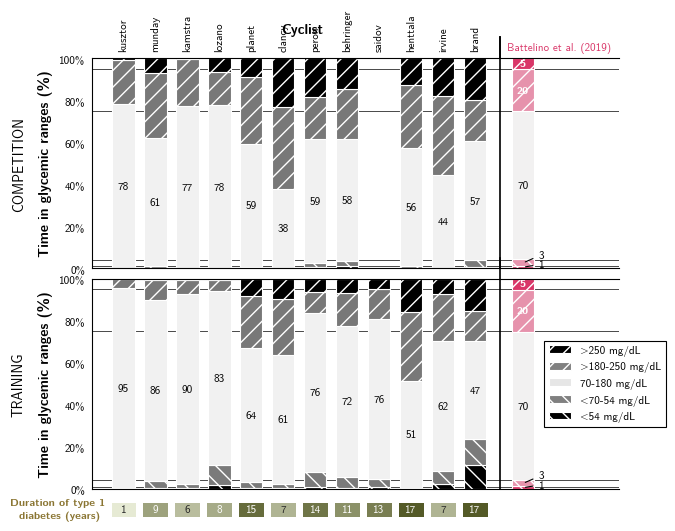

In [343]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})
MASK = {'competition': dc['race_day'] & dc['exercise'],
        'training'   : ~dc['race_day'] & dc['exercise']}
for ax, (sec, mask) in zip(axs[:2], MASK.items()):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & mask])
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], plot_numbers='half', labelsize=8)
    
    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges (%)', weight='bold')
        
    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)
 
# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Cyclist', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.5, 0.3, 'Duration of type 1 ', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.5, 0.9, 'diabetes (years)', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_competitiontrain', xticks=axs[0])

**CONCLUSION** : Large differences among athletes

### Competition vs. training

### Glucose distribution (boxplots)

In [344]:
kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=color_race['race'], hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['race']), capprops=dict(color=color_race['race'])),
		   'train':dict(boxprops=dict(color='w', facecolor=color_race['train'], hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['train']), capprops=dict(color=color_race['train']))}

All, stratify: sections

In [349]:
for _, l in list(glucose_levels.items())[1:]:
    print(l)

(54, 69.99999999)
(70, 180)
(180.00000001, 250)
(250.00000001, 10000)


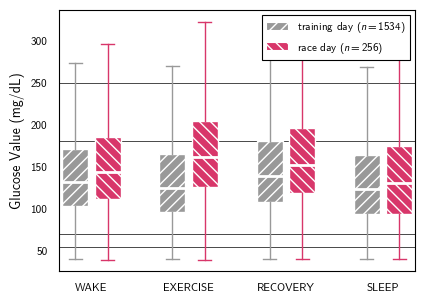

In [352]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

fig, ax = plt.subplots()

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)
    
for k, sec in enumerate(SECTIONS):
	plt.boxplot(dc.loc[dc[sec] & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[dc[sec] & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
ax.set_xticklabels([sec.upper() for sec in SECTIONS])
savefig('boxplot/box_glucose_sections')

Individual athletes, stratify: sections

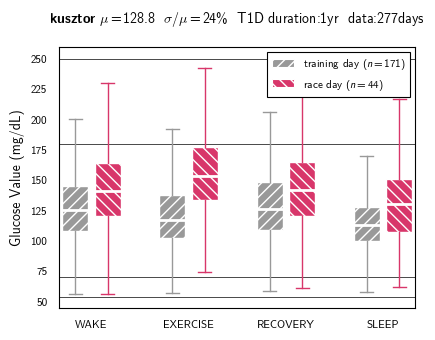

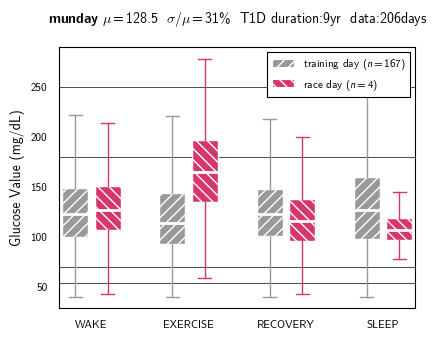

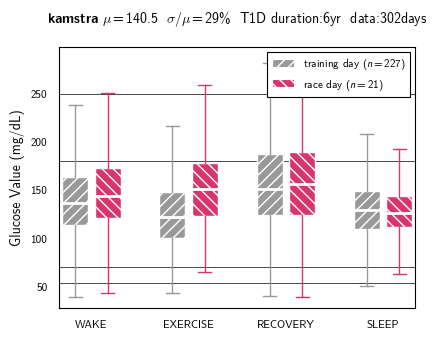

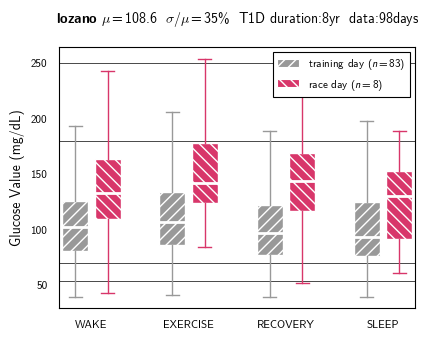

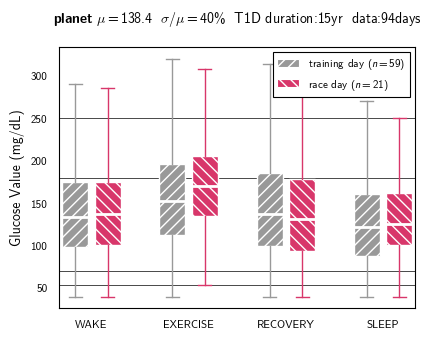

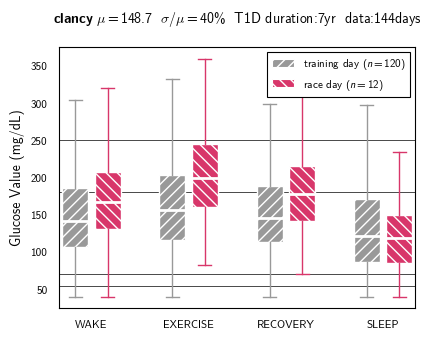

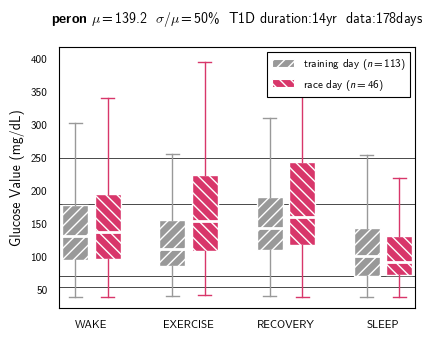

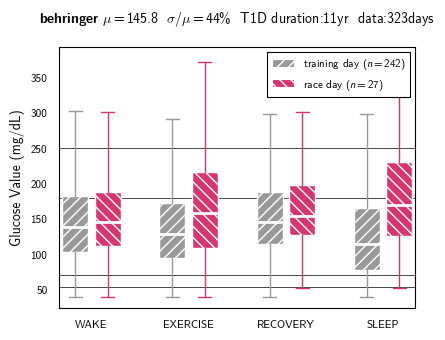

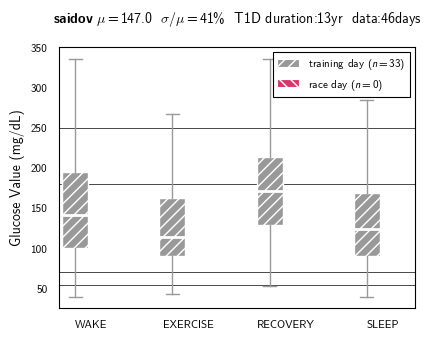

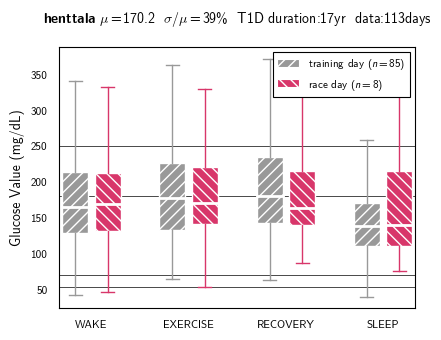

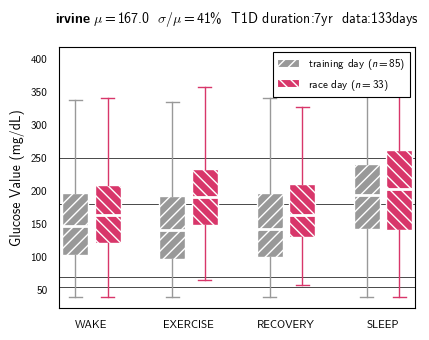

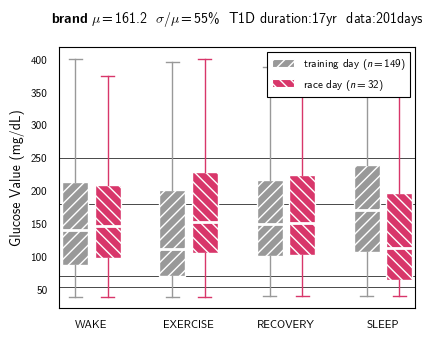

In [354]:
for i in ATHLETES:
    n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())
    n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())

    fig, ax = plt.subplots()

    # grid in plot
    for _, l in list(glucose_levels.items())[1:]:
        ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+0.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['train'])
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+1.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['race'])
    plt.xticks([1,4,7,10], SECTIONS)
    plt.ylabel(COL)
    plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
                        Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
                loc='upper right')

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
                dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    ax.set_xticklabels([sec.upper() for sec in SECTIONS])
    savefig(path='boxplot/box_glucose_sections', i=i, title=title, y=1.06)

All, stratify: athletes

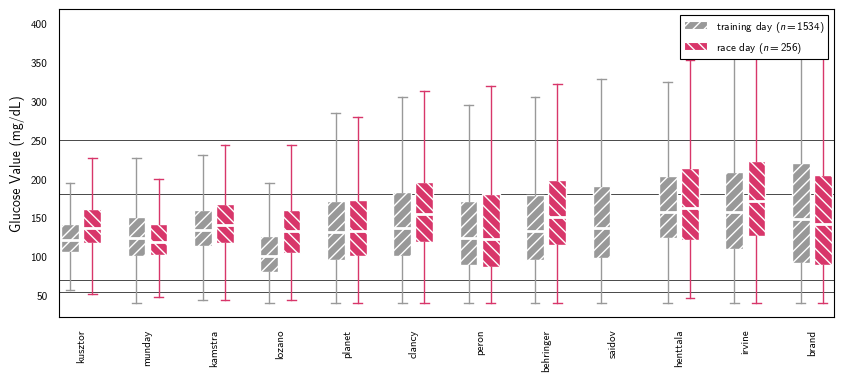

In [355]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

for n, i in enumerate(ATHLETES):
	plt.boxplot(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks(np.arange(1, len(ATHLETES)*3,3), ATHLETES)

savefig('boxplot/box_glucose_riders', xticks=ax)

### Glucose during cycling (longitudinal)

In [87]:
# session id
dc['tid'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['tid'] = dc['tid'].fillna(method='ffill')

# time within session
dc['t'] = dc.groupby('tid').cumcount() * 5
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            8 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            8 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            8 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            8 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            8 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1267159      9 2019-01-27 04:35:00                   70.0 2019-01-27 05:35:00   
1267160      9 2019-01-27 04:40:00                   72.0 2019-01-27 05:40:00   
1267161      9 2019-01-27 04:45:00                   73.0 2019-01-27 05:45:00   
1267162      9 2019-01-27 04:50:00                   54.0 2019-01-27 05:50:00   
1267163      9 2019-01-27 04:55:00                   69.0 2019-01-27 05:55:00   

         exercise  recovery   wake  sleep  race_day  travel_day       date  \
0           False     False   True  False     False       False 2018-11-05   
1           False     False   True  False     False       False 2018-11-05   
2           False     False   True  False     False       False 2018-11-05   
3           False     False   True  False     False       False 2018-11-05   
4           False     False   True  False     False       False 2018-11-05   
...           ...       ...    ...    ...       ...         ...        ...   
1267159     False     False  False   True     False       False 2019-01-27   
1267160     False     False  False   True     False       False 2019-01-27   
1267161     False     False  False   True     False       False 2019-01-27   
1267162     False     False  False   True     False       False 2019-01-27   
1267163     False     False  False   True     False       False 2019-01-27   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  \
0                True 2018-11-05        False          False             True   
1                True 2018-11-05        False          False             True   
2                True 2018-11-05        False          False             True   
3                True 2018-11-05        False          False             True   
4                True 2018-11-05        False          False             True   
...               ...        ...          ...            ...              ...   
1267159          True 2019-01-26        False          False             True   
1267160          True 2019-01-26        False          False             True   
1267161          True 2019-01-26        False          False             True   
1267162          True 2019-01-26        False          False             True   
1267163          True 2019-01-26        False          False             True   

         completeness     tid     t  
0            0.920139     0.0     0  
1            0.920139     0.0     5  
2            0.920139     0.0    10  
3            0.920139     0.0    15  
4            0.920139     0.0    20  
...               ...     ...   ...  
1267159      0.961806  1971.0  1135  
1267160      0.961806  1971.0  1140  
1267161      0.961806  1971.0  1145  
1267162      0.961806  1971.0  1150  
1267163      0.961806  1971.0  1155  

[574962 rows x 19 columns]

All

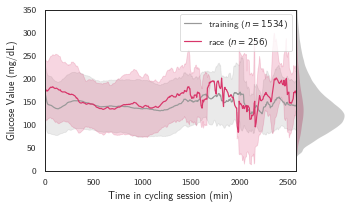

In [90]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

t_max = dc.groupby('tid')['t'].max().quantile(0.9) #dc['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(data = dc[dc['exercise_day_6h']], x='t', y=COL, hue='race_day_6h', ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(), 
	labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'+r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=dc.loc[dc['t'].notna() & dc['exercise_day_6h']], y=COL, hue='race_day_6h', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
savefig('time_cycling/glucose_cycling')

Individual athletes

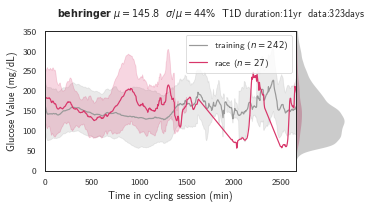

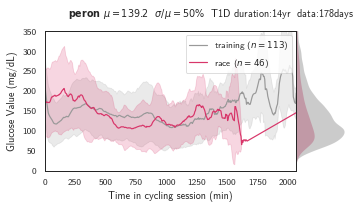

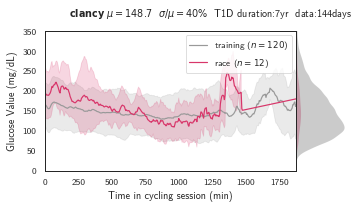

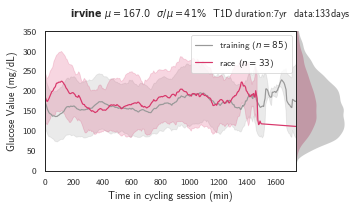

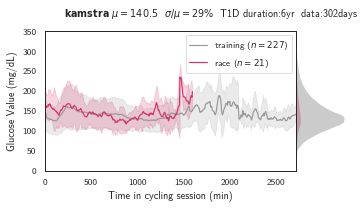

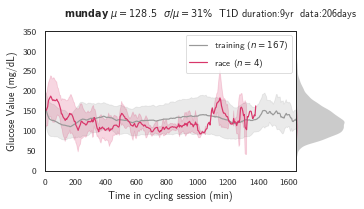

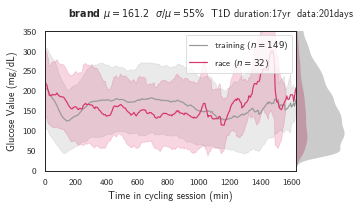

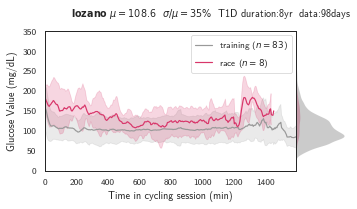

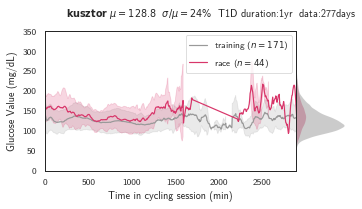

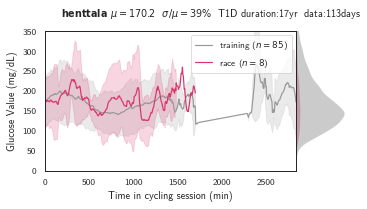

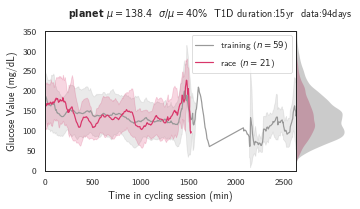

In [93]:
for i in dc[dc['race_day_6h']].RIDER.unique():
	n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())

	t_max = dc[dc.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#dc.loc[dc.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(data=dc[(dc.RIDER == i) & dc['exercise_day_6h']], x='t', y=COL, ci='sd', hue='race_day_6h', palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(),
		labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=dc.loc[dc['t'].notna() & (dc.RIDER == i) & dc['exercise_day_6h']], y=COL, hue='race_day_6h', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
				dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='time_cycling/glucose_cycling', i=i, title=title, x=-1.7, y=1.06)

### Glucose during day

In [89]:
dc['time'] = timestamp_to_seconds(dc['local_timestamp'])

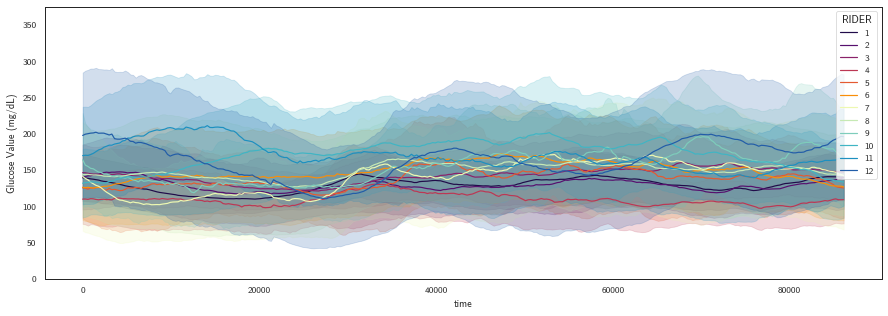

In [90]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dc, x='time', y=COL, ci='sd', hue='RIDER', palette=palette_ath)
plt.ylim((0,375))
plt.show()

### Days with hypo events (during sections)

In [104]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

In [ ]:
dc_hypo = {}
for sec in SECTIONS+('1d',):
    dc_hypo[sec] = dc_agg['hypo_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hypo = pd.concat(dc_hypo, axis=1) * 100
dc_hypo = dc_hypo.rename(columns={'1d':'total'})

In [82]:
dc_hyper = {}
for sec in SECTIONS+('1d',):
    dc_hyper[sec] = dc_agg['hyper_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hyper = pd.concat(dc_hyper, axis=1) * 100
dc_hyper = dc_hyper.rename(columns={'1d':'total'})

Text(0.5, 1.0, 'Days in hyperglycemia')

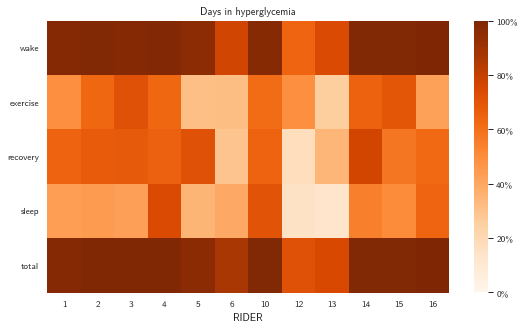

In [83]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hyper.T, vmin=0, vmax=100, cmap='Oranges')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])
plt.yticks(rotation=0)
plt.title("Days in hyperglycemia")

Text(0.5, 1.0, 'Days in hypoglycemia')

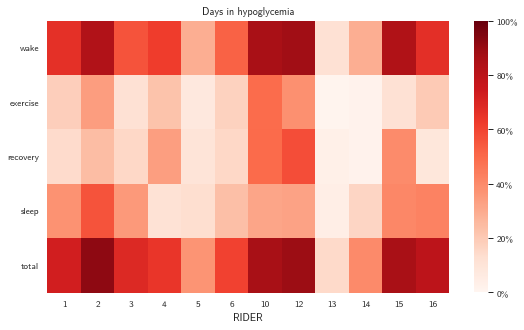

In [84]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hypo.T, vmin=0, vmax=100, cmap='Reds')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])

plt.yticks(rotation=0)
plt.title("Days in hypoglycemia")

In [85]:
dc_events = {}
for sec in SECTIONS+('1d',):
    dc_events[sec] = dc_agg[['time_in_hypo_'+sec, 'time_in_hyper_'+sec]].div(dc_agg['count_'+sec], axis=0)
    dc_events[sec].columns = ['_'.join(col.split('_')[:-1]) for col in dc_events[sec].columns]
    dc_events[sec] *= 100
    dc_events[sec] = dc_events[sec].sort_index(level=1)
    mask = (dc_events[sec]['time_in_hypo'] != 0) & (dc_events[sec]['time_in_hyper'] != 0)
    dc_events[sec].loc[mask, 'time_in_both'] = dc_events[sec]['time_in_hypo'] + dc_events[sec]['time_in_hyper']
    dc_events[sec].loc[mask, ['time_in_hypo', 'time_in_hyper']] = 0
    dc_events[sec] = dc_events[sec].replace({0:np.nan})

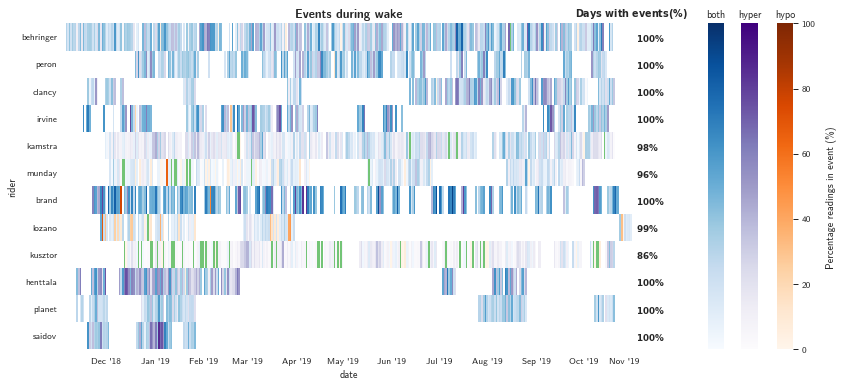

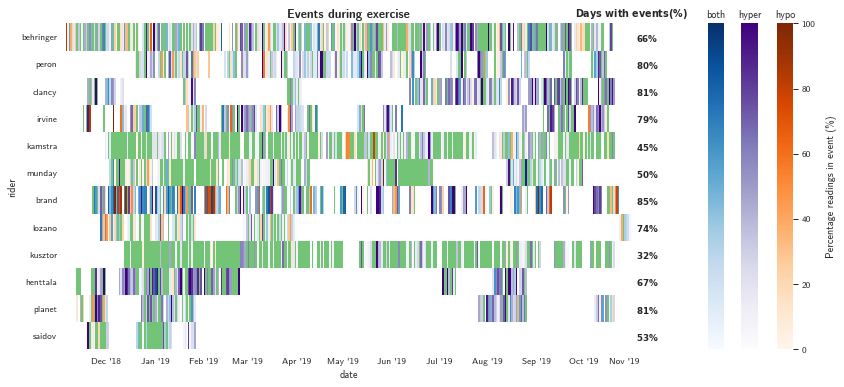

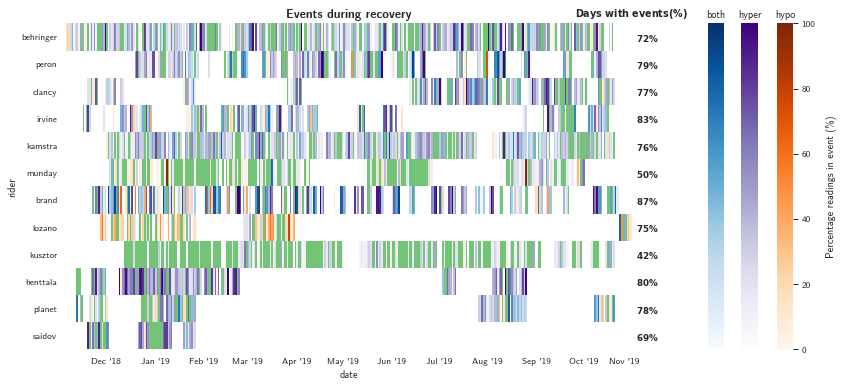

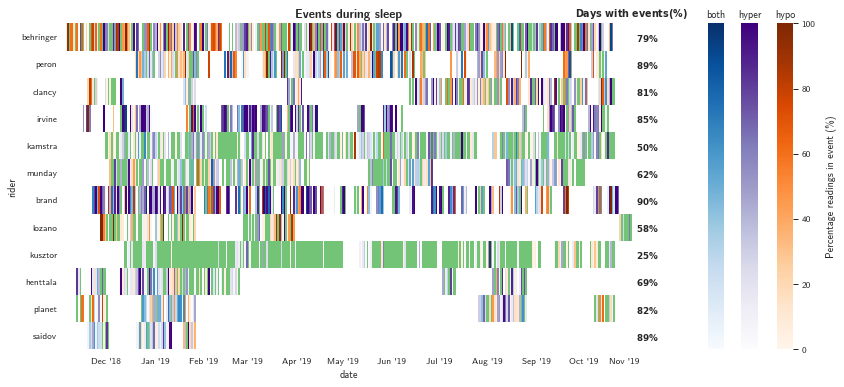

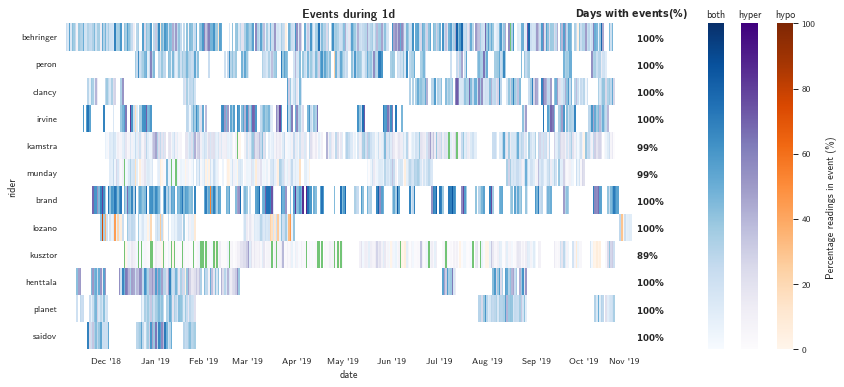

In [86]:
EVENTS = {'hypo': {'cmap':'Oranges', 'cbar_kws':{'pad':-0.1}},
          'hyper':{'cmap':'Purples', 'cbar_kws':{'pad':-0.1}}, 
          'both': {'cmap':'Blues'  , 'cbar_kws':{'pad':0.1}}}
for sec in SECTIONS+('1d',):
    fig, ax = plt.subplots(figsize=(15,6))
    
    df_avail = dc_events[sec].isna().all(axis=1).astype(float).unstack()
    sns.heatmap(df_avail, ax=ax, vmin=0, vmax=2, cmap='Greens', cbar=False)
    for event, kwargs in EVENTS.items():
        df_avail = dc_events[sec]['time_in_'+event].unstack()
        sns.heatmap(df_avail, ax=ax, vmin=0, vmax=100, **kwargs)
    
    # percentage columns
    perc_events = dc_events[sec].unstack().count(axis=1)/\
        dc_events[sec].reset_index().groupby('RIDER')['date'].count()*100
    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
    ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in perc_events])
    ax2.tick_params(axis='y', length=0)
    ax2.spines['right'].set_visible(False)
    ax.text(0.9, 1.02, r'$\bf{:s}$'.format('Days\ with\ events (\%)'), ha='left', transform=ax.transAxes) 
    
    # colorbar
    for j, cbar_ax in enumerate(fig.get_axes()[1:]):
        if j != 0:
            cbar_ax.set_yticks([]) ; cbar_ax.set_yticklabels([])
        cbar_ax.set_title(list(EVENTS.keys())[j])
        if j == 0:
            cbar_ax.text(3, dc_events[sec].max().max()/2, 'Percentage readings in event (%)', va='center', rotation=90)
            
    monthyear = df_avail.columns.strftime("%b '%y")
    ticksloc = np.where(monthyear.to_series().shift() != monthyear.to_series())[0][1:]
    plt.xticks(ticks=ticksloc, labels=monthyear[ticksloc], rotation=0)
    plt.xlabel('date')
    plt.ylabel('rider')
    plt.title('Events during '+sec, fontweight='bold', fontsize=12)
    savefig('events/events', i=sec, yticks=ax)

### Stats

**Stats for patient population**

In [ ]:
info['bmi'] = info['weight'] / (info['height']/100)**2

In [103]:
# ------ info
cols_info = {'age'    : 'Age (yr)',
             'gender' : 'Sex (male/female)',
             'height' : 'Height (cm)',
             'weight' : 'Weight (kg)',
             'bf(%)'  : 'Fat mass (\%)'}

info['FTP_per_kg'] = info['FTP'] / info['weight']
info = info.drop('FTP', axis=1)

stats_info = info.loc[:,info.columns.isin(cols_info.keys())]
stats_info = stats_info.rename(columns=cols_info)

In [104]:
# ------ diabetes
cols_diab = {'diabetes_duration' : 'Diabetes duration (yr)',
             'HbA1c'             : 'HbA_{1c} (\%)',
             'cgm_days'          : 'Days with CGM coverage $\geq$ 70 \%'}

stats_diab = info.loc[:, info.columns.isin(cols_diab.keys())]
stats_diab['cgm_days'] = dc_agg.reset_index().groupby('RIDER')['date'].count()
stats_diab = stats_diab.rename(columns=cols_diab)

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [105]:
# ------ exercise
cols_ex = {'FTP_per_kg'                : 'Functional threshold power (W/kg)',
           'LTHR'                      : 'Lactate threshold heart rate (bpm)',
           'HRmax'                     : 'HR_{max} (bpm)',
           'VO2max'                    : 'VO_{2max} (mL/min/kg)',
           'days_per_year_cycled'      : 'Cycling (days/yr)',
           'days_per_year_raced'       : 'Competition (days/yr)',
           'km_per_year_cycled'        : 'Distance cycled (km/yr)',
           'mean_hours_per_day_cycled' : 'Mean time cycled (h/day)',
           'mean_km_per_day_cycled'    : 'Mean distance cycled (km/day)',
           'mean_m_per_day_ascended'   : 'Mean ascension (m/day)'}

tp_agg0 = tp_agg.set_index(['RIDER', 'date'])
tp_agg0.columns = tp_agg0.columns.get_level_values(1)
tp_agg0 = tp_agg0.reset_index()

stats_ex_yr = tp_agg0.groupby('RIDER').agg({'date'        :'count', 
                                            'race'        :'sum', 
                                            'distance_max':lambda x: x.sum()/1000})\
                           .rename(columns={'date'        :'days_per_year_cycled',
                                            'race'        :'days_per_year_raced',
                                            'distance_max':'km_per_year_cycled'})

stats_ex_day = tp_agg0.groupby('RIDER').agg({'timestamp_count'      :lambda x: x.mean()/3600,
                                             'distance_max'         :lambda x: x.mean()/1000,
                                             'elevation_gain_up_sum':'mean'})\
    .rename(columns={'timestamp_count'      :'mean_hours_per_day_cycled',
                     'distance_max'         :'mean_km_per_day_cycled',
                     'elevation_gain_up_sum':'mean_m_per_day_ascended'})

stats_ex = info[sorted(set(cols_ex.keys()) & set(info.columns))]
stats_ex = pd.merge(stats_ex, stats_ex_yr, left_index=True, right_index=True, how='outer')
stats_ex = pd.merge(stats_ex, stats_ex_day, left_index=True, right_index=True, how='outer')
stats_ex = stats_ex.rename(columns=cols_ex)

In [106]:
stats = pd.concat([stats_info, stats_diab, stats_ex], axis=1)
stats

Sex (male/female)  Age (yr)  Weight (kg)  Fat mass (\%)  Height (cm)  \
RIDER                                                                        
1                     M        34    60.333333       4.866667        179.0   
2                     M        20    56.700000       4.950000        169.0   
3                     M        25    69.633333       7.700000        183.0   
4                     M        30    64.000000       5.600000        178.0   
5                     M        25    73.766667       7.200000        179.0   
6                     M        26    66.733333       6.566667        171.0   
7                     M        30    71.633333       8.833333        178.0   
8                     M        22    60.500000       9.066667        174.0   
9                     M        22    56.666667       9.466667        170.0   
10                    M        27    75.166667       9.333333        187.0   
11                    M        19    78.666667       9.433333        178.0   
12                    M        27    75.466667       7.700000        185.0   

       Diabetes duration (yr)  HbA_{1c} (\%)  \
RIDER                                          
1                           1       6.366667   
2                           9       6.550000   
3                           6       6.725000   
4                           8       5.950000   
5                          15       6.525000   
6                           7       6.850000   
7                          14       6.533333   
8                          11       6.333333   
9                          13       6.825000   
10                         17       6.925000   
11                          7       8.000000   
12                         17       7.233333   

       Days with CGM coverage $\geq$ 70 \%  Functional threshold power (W/kg)  \
RIDER                                                                           
1                                      277                           5.729282   
2                                      206                           5.264550   
3                                      302                           4.897080   
4                                       98                           5.421875   
5                                       94                           5.273385   
6                                      144                           4.465534   
7                                      178                           4.550954   
8                                      323                           5.074380   
9                                       46                           5.000000   
10                                     113                           4.629712   
11                                     133                           4.525424   
12                                     201                           5.000000   

       HR_{max} (bpm)  Lactate threshold heart rate (bpm)  \
RIDER                                                       
1          182.333333                          173.000000   
2          184.500000                          173.000000   
3          192.666667                          179.666667   
4          178.666667                          158.333333   
5          198.000000                          185.000000   
6          180.000000                          171.000000   
7          181.666667                          168.666667   
8          192.333333                          176.333333   
9          200.333333                          125.610000   
10         189.500000                          169.000000   
11         187.333333                          170.333333   
12         194.333333                          177.000000   

       VO_{2max} (mL/min/kg)  Cycling (days/yr)  Competition (days/yr)  \
RIDER                                                                    
1                  76.666667                233                     46   
2                  70.781588

Calculate mean and std over all riders and write to latex

In [107]:
def agg_gender(x):
    count = x.value_counts()
    male = count['M'] if 'M' in count else 0
    female = count['F'] if 'F' in count else 0
    return f'{male}/{female}'

In [108]:
stats_agg = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1).round(1)
stats_agg = pd.concat([pd.Series(stats['Sex (male/female)'].agg(agg_gender), index=['Sex (male/female)']),
                       stats_agg])

stats_agg = stats_agg.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
stats_agg.to_csv(SAVE_PATH+"stats.csv")

In [109]:
stats_agg

median      p25      p75
Sex (male/female)                       12/0      NaN      NaN
Age (yr)                                25.5     22.0     27.8
Weight (kg)                             68.2     60.5     74.1
Fat mass (\%)                            7.7      6.3      9.1
Height (cm)                            178.0    173.2    180.0
Diabetes duration (yr)                  10.0      7.0     14.2
HbA_{1c} (\%)                            6.6      6.5      6.9
Days with CGM coverage $\geq$ 70 \%    161.0    109.2    223.8
Functional threshold power (W/kg)        5.0      4.6      5.3
HR_{max} (bpm)                         188.4    182.2    193.1
Lactate threshold heart rate (bpm)     172.0    168.9    176.5
VO_{2max} (mL/min/kg)                   69.8     66.9     74.2
Cycling (days/yr)                      288.5    254.0    300.5
Competition (days/yr)                   36.0     23.0     47.2
Distance cycled (km/yr)              25042.6  22698.8  29268.4
Mean time cycled (h/day)                 3.1      3.0      3.3
Mean distance cycled (km/day)           97.1     89.3    103.2
Mean ascension (m/day)                1229.9   1123.2   1317.5

In [110]:
stats_agg = stats_agg.apply(lambda x: f"{x['median']} & ({x['p25']} & {x['p75']})", axis=1)

with open(SAVE_PATH+"stats.tex", 'w') as file:
	file.write(stats_agg.to_latex(column_format='c', escape=False))

**Stats for CGM**

In [130]:
cols_cgm = {'glucose_mean'    : 'Mean glucose (mg/dL)',
            'glucose_cv'      : 'Glycemic variability (\%)',
            'time_in_hypo'    : 'hypoglycemia (<70 mg/dL)',
            'time_in_hypoL2'  : 'hypoglycemia L2 (<54 mg/dL)',
            'time_in_hypoL1'  : 'hypoglycemia L1 (54-69 mg/dL)',
            'time_in_target'  : 'target range (70-180 mg/dL)',
            'time_in_hyper'   : 'hyperglycemia (>180 mg/dL)',
            'time_in_hyperL1' : 'hyperglycemia L1 (181-250 mg/dL)',
            'time_in_hyperL2' : 'hyperglycemia L2 (>250 mg/dL)'}

In [131]:
# TODO: check if still in line with new value of glucose_levels
# calculate dysglycemia events
dc['hypo'] = dc.groupby('RIDER')[COL].transform(lambda x: (x <= glucose_levels['hypo L1'][1]) \
														& (x.shift(1) <= glucose_levels['hypo L1'][1]) \
														& (x.shift(2) <= glucose_levels['hypo L1'][1]))
dc['hyper'] = dc.groupby('RIDER')[COL].transform(lambda x: (x >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(1) >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(2) >= glucose_levels['hyper L1'][0]))

# glucose rate
dc['glucose_rate'] = dc[COL] / (dc['timestamp'].diff()/pd.to_timedelta('5min'))

In [132]:
stat_cols = ['Total', 'exercise', 'recovery', 'wake', 'sleep']

In [133]:
def get_stats_cgm(dc):
    stats = {'Total': dc.groupby('RIDER').apply(stat_func).apply(pd.Series)}
    stats.update({sec: dc[dc[sec]].groupby('RIDER').apply(stat_func).apply(pd.Series) for sec in SECTIONS})
    
    for k, df in stats.items():
        df.columns = df.columns.str.rstrip('_')
        cols_time = df.columns.str.startswith('time_in')
        df.loc[:, cols_time] = df.loc[:, cols_time].div(df['count'], axis=0) * 100 # calculate perc
        df['glucose_cv'] *= 100
        df = df[['glucose_mean', 'glucose_cv', 'time_in_hypoL2', 'time_in_hypoL1',
           'time_in_target', 'time_in_hyperL1', 'time_in_hyperL2']]
        stats[k] = df
    stats = pd.concat(stats, axis=1)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # some overly difficult way to get it to the right format
    stats.index = stats.index.swaplevel(0,1)
    stats = stats.unstack()
    stats.columns = stats.columns.swaplevel(0,1)
    
    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    
    return stats

In [134]:
def highlight_cell(stats, col, func):
    stats.loc[col, pd.IndexSlice[:,'median']] = stats.loc[col,pd.IndexSlice[:,'median']].applymap(func)
    return stats

In [135]:
days = {'all'   : dc,
        'race'  : dc[dc['exercise_day_6h'] & dc['race_day_6h']],
        'train' : dc[dc['exercise_day_6h'] & ~dc['race_day_6h']]}

In [136]:
tnames = {'all'  : r"All days (d={:.0f})".format(len(days['all'][['RIDER', 'date_6h']].drop_duplicates())),
          'race' : r"Competition days (d={:.0f})".format(len(days['race'][['RIDER', 'date_6h']].drop_duplicates())),
          'train': r"Training days (d={:.0f})".format(len(days['train'][['RIDER', 'date_6h']].drop_duplicates()))}
tnames

{'all': 'All days (d=2115)',
 'race': 'Competition days (d=256)',
 'train': 'Training days (d=1534)'}

In [137]:
stats_cgm = {name: get_stats_cgm(df) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm.to_csv(SAVE_PATH+"stats_cgm.csv")

In [138]:
stats_cgm

Total               exercise                \
                                 median    p25    p75   median    p25    p75   
All days (d=2115)                   NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)              145.3  135.3  157.0    143.6  130.4  163.0   
Glycemic variability (\%)          39.9   34.0   41.7     36.9   34.9   44.3   
hypoglycemia L2 (<54 mg/dL)         1.3    0.4    2.9      0.5    0.2    1.1   
hypoglycemia L1 (54-69 mg/dL)       4.2    2.2    6.4      3.4    2.0    4.9   
target range (70-180 mg/dL)        66.1   62.4   82.2     71.0   58.7   83.0   
hyperglycemia L1 (181-250 mg/dL)   17.9   12.6   22.2     14.5    9.3   26.8   
hyperglycemia L2 (>250 mg/dL)       7.0    1.4    9.7      7.9    1.3   10.6   
Competition days (d=256)            NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)              143.6  139.4  160.3    170.6  160.3  178.0   
Glycemic variability (\%)          37.5   29.4   39.8     30.0   29.1   38.0   
hypoglycemia L2 (<54 mg/dL)         0.6    0.3    1.7      0.0    0.0    0.2   
hypoglycemia L1 (54-69 mg/dL)       2.4    1.4    4.1      0.5    0.1    1.5   
target range (70-180 mg/dL)        64.1   60.3   84.7     58.6   56.4   68.9   
hyperglycemia L1 (181-250 mg/dL)   18.1   12.8   24.4     23.6   20.3   31.3   
hyperglycemia L2 (>250 mg/dL)       6.9    1.2   11.8     12.0    7.0   18.0   
Training days (d=1534)              NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)              141.8  135.6  151.1    137.5  125.6  151.4   
Glycemic variability (\%)          40.6   33.4   42.3     37.5   35.0   44.3   
hypoglycemia L2 (<54 mg/dL)         1.5    0.4    2.7      0.6    0.2    1.1   
hypoglycemia L1 (54-69 mg/dL)       4.8    2.2    6.8      3.4    2.2    6.3   
target range (70-180 mg/dL)        67.4   64.6   82.4     74.0   61.8   83.5   
hyperglycemia L1 (181-250 mg/dL)   16.9   11.6   21.2     14.1    8.4   22.7   
hyperglycemia L2 (>250 mg/dL)       5.7    1.4    8.5      6.6    0.9    8.6   

                                 recovery                 wake                \
                                   median    p25    p75 median    p25    p75   
All days (d=2115)                     NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)                157.3  141.8  165.1  150.4  138.3  160.7   
Glycemic variability (\%)            35.5   32.7   41.9   38.9   33.3   40.9   
hypoglycemia L2 (<54 mg/dL)           0.5    0.2    1.5    0.8    0.3    1.9   
hypoglycemia L1 (54-69 mg/dL)         2.3    1.4    4.5    3.5    1.9    5.2   
target range (70-180 mg/dL)          67.2   59.1   72.6   66.6   59.2   81.9   
hyperglycemia L1 (181-250 mg/dL)     21.9   16.1   24.1   18.7   13.4   23.7   
hyperglycemia L2 (>250 mg/dL)         6.5    3.2   11.2    6.9    1.4   10.0   
Competition days (d=256)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)                164.3  144.4  178.4  153.3  142.7  166.1   
Glycemic variability (\%)            32.8   28.7   41.0   36.9   30.2   38.0   
hypoglycemia L2 (<54 mg/dL)           0.3    0.0    0.8    0.5    0.3    1.4   
hypoglycemia L1 (54-69 mg/dL)         1.6    0.8    3.8    2.2    0.9    3.9   
target range (70-180 mg/dL)          64.9   58.2   75.7   68.8   58.2   81.5   
hyperglycemia L1 (181-250 mg/dL)     20.8   15.3   25.3   18.7   15.3   25.0   
hyperglycemia L2 (>250 mg/dL)         7.7    1.9   14.4    6.0    1.6   11.7   
Training days (d=1534)                NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)                154.6  142.9  159.8  146.6  138.2  151.9   
Glycemic variability (\%)            35.6   32.8   40.8   39.2   32.8   41.0   
hypoglycemia L2 (<54 mg/dL)           0.4    0.2    1.3    0.8    0.3    1.7   
hypoglycemia L1 (54-69 mg/dL)         2.3    1.4    4.2    4.3    2.0    5.1   
target range (70-180 mg/dL)          68.5   59.5   72.6   68.5   63.2   82.6   
hyperglycemia L1 (181-250 mg/dL) 

In [139]:
#stats_cgm = highlight_cell(stats_cgm, 'Mean glucose (mg/dL)', lambda x: pd.DataFrame(False, index=x.index, columns=x.columns))
stats_cgm = highlight_cell(stats_cgm, 'Glycemic variability (\%)', lambda x: '\hl'+str(x) if x > 37 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L2 (<54 mg/dL)', lambda x: '\hl'+str(x) if x > 1 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L1 (54-69 mg/dL)', lambda x: '\hl'+str(x) if x > 3 else x)
stats_cgm = highlight_cell(stats_cgm, 'target range (70-180 mg/dL)', lambda x: '\hl'+str(x) if x < 70 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L1 (181-250 mg/dL)', lambda x: '\hl'+str(x) if x > 20 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L2 (>250 mg/dL)', lambda x: '\hl'+str(x) if x > 5 else x)

In [140]:
stats_cgm.index = pd.MultiIndex.from_arrays([8*['all']+8*['comp']+8*['train'], stats_cgm.index])
stats_cgm.columns = stats_cgm.columns.swaplevel(0,1)
stats_cgm = stats_cgm.stack(dropna=False)
#stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} ({x['p25']} - {x['p75']})", axis=1)
stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} & \hl({x['p25']} - {x['p75']})" if str(x['median']).startswith('\hl') else (f"{x['median']} & ({x['p25']} - {x['p75']})" if x.isna().sum() != 3 else np.nan), axis=1)
stats_cgm = stats_cgm.unstack()
stats_cgm = stats_cgm.sort_index(key=lambda x: x.map({**{k:i for i, k in enumerate(tnames.keys())}, **{k:0 for k in tnames.values()}, **{k:i+1 for i, k in enumerate(cols_cgm.values())}}))
stats_cgm = stats_cgm[stat_cols]
stats_cgm = stats_cgm.rename(index={k: '\hspace{7mm}'+k for k in list(cols_cgm.values())[2:]})
stats_cgm = stats_cgm.reset_index().drop('level_0', axis=1).set_index('level_1')
with open(SAVE_PATH+"stats_cgm.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='lrrrrr', escape=False))

Combine L1 and L2

In [141]:
def get_stats_cgm2(dc):
    stats = {'Total': dc.groupby('RIDER').apply(stat_func).apply(pd.Series)}
    stats.update({sec: dc[dc[sec]].groupby('RIDER').apply(stat_func).apply(pd.Series) for sec in SECTIONS})
    
    for k, df in stats.items():
        df.columns = df.columns.str.rstrip('_')
        cols_time = df.columns.str.startswith('time_in')
        df.loc[:, cols_time] = df.loc[:, cols_time].div(df['count'], axis=0) * 100 # calculate perc
        df['glucose_cv'] *= 100
        df = df[['glucose_mean', 'glucose_cv', 'time_in_hypo', 'time_in_target', 'time_in_hyper', ]]
        stats[k] = df
    stats = pd.concat(stats, axis=1)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # some overly difficult way to get it to the right format
    stats.index = stats.index.swaplevel(0,1)
    stats = stats.unstack()
    stats.columns = stats.columns.swaplevel(0,1)
    
    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    
    return stats

In [142]:
stats_cgm = {name: get_stats_cgm2(df) for name, df in days.items()}
stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

Total               exercise                \
                            median    p25    p75   median    p25    p75   
All days (d=2115)              NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)         145.3  135.3  157.0    143.6  130.4  163.0   
Glycemic variability (\%)     39.9   34.0   41.7     36.9   34.9   44.3   
hypoglycemia (<70 mg/dL)       5.3    2.6    9.2      4.0    2.2    6.0   
target range (70-180 mg/dL)   66.1   62.4   82.2     71.0   58.7   83.0   
hyperglycemia (>180 mg/dL)    25.3   14.1   33.8     23.1   10.2   35.8   
Competition days (d=256)       NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)         143.6  139.4  160.3    170.6  160.3  178.0   
Glycemic variability (\%)     37.5   29.4   39.8     30.0   29.1   38.0   
hypoglycemia (<70 mg/dL)       2.5    2.0    5.8      0.5    0.1    1.7   
target range (70-180 mg/dL)   64.1   60.3   84.7     58.6   56.4   68.9   
hyperglycemia (>180 mg/dL)    24.7   13.9   33.6     38.4   30.4   41.6   
Training days (d=1534)         NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose (mg/dL)         141.8  135.6  151.1    137.5  125.6  151.4   
Glycemic variability (\%)     40.6   33.4   42.3     37.5   35.0   44.3   
hypoglycemia (<70 mg/dL)       6.1    2.6    9.7      4.1    2.4    8.1   
target range (70-180 mg/dL)   67.4   64.6   82.4     74.0   61.8   83.5   
hyperglycemia (>180 mg/dL)    23.1   13.0   30.7     20.8    9.3   30.5   

                            recovery                 wake                \
                              median    p25    p75 median    p25    p75   
All days (d=2115)                NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)           157.3  141.8  165.1  150.4  138.3  160.7   
Glycemic variability (\%)       35.5   32.7   41.9   38.9   33.3   40.9   
hypoglycemia (<70 mg/dL)         2.7    1.6    6.1    4.6    2.3    7.2   
target range (70-180 mg/dL)     67.2   59.1   72.6   66.6   59.2   81.9   
hyperglycemia (>180 mg/dL)      29.9   21.6   34.4   27.3   14.9   35.8   
Competition days (d=256)         NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)           164.3  144.4  178.4  153.3  142.7  166.1   
Glycemic variability (\%)       32.8   28.7   41.0   36.9   30.2   38.0   
hypoglycemia (<70 mg/dL)         1.6    0.9    5.3    3.0    1.3    5.0   
target range (70-180 mg/dL)     64.9   58.2   75.7   68.8   58.2   81.5   
hyperglycemia (>180 mg/dL)      31.1   19.5   39.5   27.9   17.1   37.1   
Training days (d=1534)           NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose (mg/dL)           154.6  142.9  159.8  146.6  138.2  151.9   
Glycemic variability (\%)       35.6   32.8   40.8   39.2   32.8   41.0   
hypoglycemia (<70 mg/dL)         2.8    1.6    5.6    5.2    2.3    6.8   
target range (70-180 mg/dL)     68.5   59.5   72.6   68.5   63.2   82.6   
hyperglycemia (>180 mg/dL)      28.8   21.9   32.9   25.1   13.8   31.7   

                             sleep                
                            median    p25    p75  
All days (d=2115)              NaN    NaN    NaN  
Mean glucose (mg/dL)         134.9  126.1  143.5  
Glycemic variability (\%)     40.3   36.0   46.8  
hypoglycemia (<70 mg/dL)       9.4    3.5   15.1  
target range (70-180 mg/dL)   72.4   62.4   80.7  
hyperglycemia (>180 mg/dL)    17.2   12.3   23.1  
Competition days (d=256)       NaN    NaN    NaN  
Mean glucose (mg/dL)         129.2  123.0  153.4  
Glycemic variability (\%)     35.7   25.5   44.4  
hypoglycemia (<70 mg/dL)       4.2    0.8   12.6  
target range (70-180 mg/dL)   73.8   58.0   93.1  
hyperglycemia (>180 mg/dL)    12.6    4.3   32.7  
Training days (d=1534)         NaN    NaN    NaN  
Mean glucose (mg/dL)         133.2  124.9  138.5  
Glycemic variability (\%)     41.0   35.0   47.1  
hypoglycemia (<70 mg/dL)      10.5    3.6   13.8  
target range (70-180 mg/dL)   70.6   62.0   80.2  
hyperglycemia (>180 mg/dL)    16.7   12.4   21.4

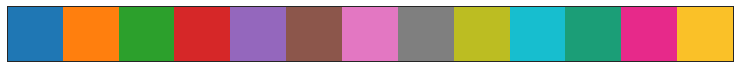

In [196]:
sns.palplot(sns.color_palette('tab10')+[sns.color_palette('Dark2')[0],
                                        sns.color_palette('Dark2')[3],
                                        sns.color_palette('inferno')[-1],
                                        sns.color_palette('inferno')])

In [432]:
sns.color_palette('YlGnBu', n_colors=6)

[(0.9101268742791234, 0.9649365628604383, 0.6956401384083045),
 (0.6984544405997694, 0.8818608227604767, 0.7138485198000769),
 (0.39601691657054977, 0.7660745866974241, 0.7481430219146482),
 (0.1729642445213379, 0.6295117262591311, 0.759523260284506),
 (0.12764321414840446, 0.42666666666666664, 0.6861361014994233),
 (0.14357554786620533, 0.22523644752018454, 0.5905420991926182)]

In [433]:
sns.color_palette('inferno', n_colors=6)

[(0.15585, 0.044559, 0.325338),
 (0.397674, 0.083257, 0.433183),
 (0.621685, 0.164184, 0.388781),
 (0.832299, 0.283913, 0.257383),
 (0.961293, 0.488716, 0.084289),
 (0.981173, 0.759135, 0.156863)]

In [434]:
sns.color_palette('gist_earth_r', n_colors=6)

[(0.8342929845025828, 0.6922737254901962, 0.5786758598521375),
 (0.7241726272770749, 0.7035188948306594, 0.37379467833956326),
 (0.5107321752862218, 0.6620551820728292, 0.32917535903993705),
 (0.25661406784936197, 0.5855013377926422, 0.32284437777281283),
 (0.19002743319550042, 0.5042304347826088, 0.49565724681625223),
 (0.09408431928011998, 0.25456763098682095, 0.4747997187719709)]

In [461]:
sns.color_palette('CMRmap')

[(0.16941176470588235, 0.15, 0.5323529411764706),
 (0.3870588235294118, 0.16450980392156864, 0.6774509803921569),
 (0.7678431372549019, 0.22098039215686274, 0.3531372549019608),
 (0.9419607843137255, 0.3950980392156863, 0.06294117647058822),
 (0.9, 0.6774509803921569, 0.07098039215686275),
 (0.9, 0.8805882352941177, 0.44823529411764707)]

In [464]:
sns.color_palette('plasma')

[(0.32515, 0.006915, 0.639512),
 (0.546157, 0.038954, 0.64701),
 (0.723444, 0.196158, 0.538981),
 (0.85975, 0.360588, 0.406917),
 (0.95547, 0.533093, 0.28549),
 (0.994495, 0.74088, 0.166335)]

In [465]:
sns.color_palette('inferno')

[(0.15585, 0.044559, 0.325338),
 (0.397674, 0.083257, 0.433183),
 (0.621685, 0.164184, 0.388781),
 (0.832299, 0.283913, 0.257383),
 (0.961293, 0.488716, 0.084289),
 (0.981173, 0.759135, 0.156863)]

In [466]:
sns.color_palette('rocket')

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

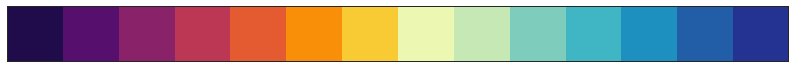

In [474]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('YlGnBu', n_colors=7))

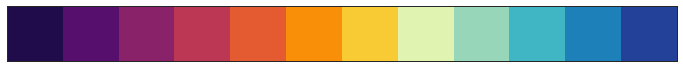

In [475]:
sns.palplot(sns.color_palette('inferno', n_colors=7)+sns.color_palette('YlGnBu', n_colors=5))

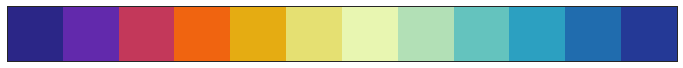

In [469]:
sns.palplot(sns.color_palette('CMRmap', n_colors=6)+sns.color_palette('YlGnBu', n_colors=6))

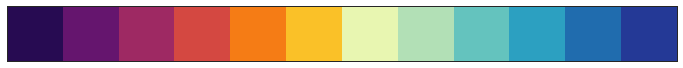

In [470]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('YlGnBu', n_colors=6))

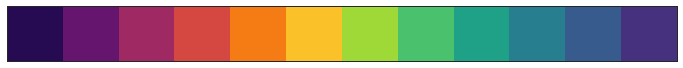

In [435]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('viridis_r', n_colors=6))

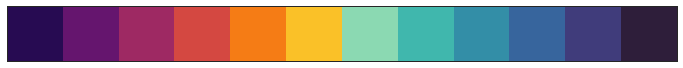

In [436]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('mako_r', n_colors=6))

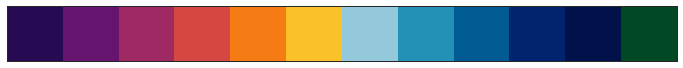

In [437]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('ocean_r', n_colors=6))

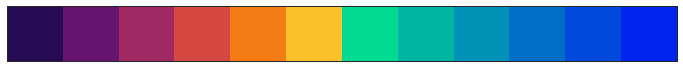

In [438]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('winter_r', n_colors=6))

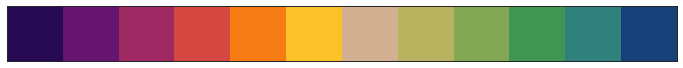

In [439]:
sns.palplot(sns.color_palette('inferno', n_colors=6)+sns.color_palette('gist_earth_r', n_colors=6))

In [440]:
sns.color_palette('tab20b')

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)]

In [441]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [442]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [443]:
sns.color_palette('gist_stern')

[(0.5691674045962472, 0.1411764705882353, 0.2823529411764706),
 (0.28627450980392155, 0.28627450980392155, 0.5725490196078431),
 (0.42745098039215684, 0.42745098039215684, 0.8549019607843137),
 (0.5725490196078431, 0.5725490196078431, 0.6912807676261994),
 (0.7137254901960784, 0.7137254901960784, 0.09052982895285744),
 (0.8588235294117648, 0.8588235294117647, 0.4672586015538292)]

In [444]:
sns.color_palette('brg')

[(0.2823529411764706, 0.0, 0.7176470588235294),
 (0.5725490196078431, 0.0, 0.4274509803921569),
 (0.8549019607843137, 0.0, 0.14509803921568631),
 (0.8549019607843137, 0.1450980392156863, 0.0),
 (0.5725490196078431, 0.42745098039215684, 0.0),
 (0.2823529411764706, 0.7176470588235294, 0.0)]

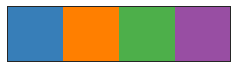

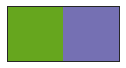

In [445]:
sns.palplot(color_sec.values()) ; plt.show()

sns.palplot([sns.color_palette('Dark2')[4], sns.color_palette('Dark2')[2]]) ; plt.show()

In [446]:
import seaborn as sns
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [447]:
sns.color_palette('Set1')

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [448]:
from plot import palette_ath

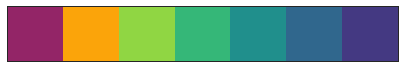

In [449]:
sns.palplot(sns.color_palette('inferno', n_colors=4)[1::2]+sns.color_palette('viridis_r', n_colors=5))

In [450]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [451]:
sns.color_palette('Set3')

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [452]:
sns.color_palette('Set1')

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [453]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [454]:
sns.color_palette('tab20', n_colors=14)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)]

In [455]:
sns.color_palette('tab20b')

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
 (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 (0.8705882352941177, 0.6196078431372549, 0.8392156862745098)]

In [456]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [457]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [458]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [459]:
sns.color_palette('gist_stern', n_colors=14)

[(0.9403811230585424, 0.06666666666666667, 0.13333333333333333),
 (0.6082425328554361, 0.13333333333333333, 0.26666666666666666),
 (0.27610394265232974, 0.2, 0.4),
 (0.26666666666666666, 0.26666666666666666, 0.5333333333333333),
 (0.3333333333333333, 0.3333333333333333, 0.6666666666666666),
 (0.4, 0.4, 0.8),
 (0.4666666666666667, 0.4666666666666667, 0.9333333333333333),
 (0.5333333333333333, 0.5333333333333333, 0.8581560283687943),
 (0.6, 0.6, 0.5744680851063828),
 (0.6666666666666667, 0.6666666666666666, 0.2907801418439714),
 (0.7333333333333334, 0.7333333333333333, 0.007092198581559961),
 (0.7999999999999999, 0.8, 0.24528301886792472),
 (0.8666666666666667, 0.8666666666666667, 0.4968553459119498),
 (0.9333333333333333, 0.9333333333333333, 0.7484276729559749)]

In [460]:
sns.color_palette('brg')

[(0.2823529411764706, 0.0, 0.7176470588235294),
 (0.5725490196078431, 0.0, 0.4274509803921569),
 (0.8549019607843137, 0.0, 0.14509803921568631),
 (0.8549019607843137, 0.1450980392156863, 0.0),
 (0.5725490196078431, 0.42745098039215684, 0.0),
 (0.2823529411764706, 0.7176470588235294, 0.0)]

In [467]:
sns.color_palette('Spectral', n_colors=12)

[(0.7803152633602461, 0.182160707420223, 0.2968089196462899),
 (0.8996539792387543, 0.340715109573241, 0.2848904267589389),
 (0.9679354094579008, 0.5074202229911572, 0.2996539792387543),
 (0.9923875432525952, 0.6938869665513263, 0.3900807381776239),
 (0.9954632833525567, 0.8476739715494039, 0.519261822376009),
 (0.9985390234525182, 0.9547097270280661, 0.6730488273740869),
 (0.9634755863129566, 0.9853902345251826, 0.6920415224913495),
 (0.8656670511341794, 0.9460207612456749, 0.6034602076124567),
 (0.6841983852364477, 0.8722029988465976, 0.6403690888119954),
 (0.48489042675893923, 0.7940023068050751, 0.6458285274894272),
 (0.30403690888119955, 0.6537485582468281, 0.6913494809688582),
 (0.24006151480199922, 0.47635524798154555, 0.7141868512110727)]

In [468]:
sns.color_palette('RdYlBu', n_colors=12)

[(0.7931564782775855, 0.14025374855824682, 0.15194156093810074),
 (0.9033448673587082, 0.314878892733564, 0.2110726643598616),
 (0.9679354094579008, 0.5074202229911572, 0.2996539792387543),
 (0.9923875432525952, 0.6938869665513263, 0.3912341407151095),
 (0.9954632833525567, 0.8476739715494039, 0.5357939254133024),
 (0.9985390234525182, 0.9547097270280661, 0.6803537101114956),
 (0.9547097270280662, 0.9824682814302191, 0.8322952710495962),
 (0.8458285274894274, 0.9369473279507883, 0.9633217993079586),
 (0.682814302191465, 0.8569780853517879, 0.9171856978085352),
 (0.5225682429834682, 0.7325643983083432, 0.8491349480968859),
 (0.3681660899653979, 0.5750865051903115, 0.7660899653979238),
 (0.25059592464436753, 0.39584775086505186, 0.6748942714340639)]